# Hubble Source Catalog SWEEPS Proper Motion Notebook
### June 2019, Steve Lubow and Rick White

This notebook shows how to access the new proper motions available for the [SWEEPS](https://media.stsci.edu/news_release/news/2011-16) field in version 3.1 of the [Hubble Source Catalog](https://archive.stsci.edu/hst/hsc).  Data tables in [MAST CasJobs](https://mastweb.stsci.edu/hcasjobs) are queried from Python using the [mastcasjobs](https://github.com/rlwastro/mastcasjobs) module.  Additional information is available on the
[SWEEPS Proper Motions help page](https://archive.stsci.edu/hst/hsc/help/sweeps/hsc_sweeps_pm.html).

This notebook is available for [download](sweeps_hscv3p1.ipynb).

·# Instructions:
* Complete the initialization steps [described below](#Initialization).
* Run the notebook to completion.
* Modify and rerun any sections of the Table of Contents below.

Running the notebook from top to bottom takes about 7 minutes (depending on the speed of your computer).


# Table of Contents
* [Intialization](#Initialization)
* [Properties of Full Catalog](#fullcat)
    * [Sky Coverage](#SkyCoverage)
    * [Proper Motion Distributions](#pmhist)
    * [Visit Distribution](#visitshist)
    * [Time Coverage Distributions](#timehist)
    * [Magnitude Distributions](#maghist)
    * [Color Magnitude Diagram](#cmdall)
    * [Detection Positions](#detpos)
* [Good Photometric Objects](#goodphot)
* [Science Applications](#sciap)
    * [Proper Motions on the CMD](#goodpm)
    * [Proper Motions in Bulge Versus Disk](#bulgedisk)
    * [White Dwarfs](#wd)
    * [QSO Candidates](#qsocan)
    * [High Proper Motion Objects](#hpm)
    * [HLA Cutout Images for Selected Objects](#cutouts)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

_This notebook requires the use of **Python 3**._

This needs some special modules in addition to the common requirements of `astropy`, `numpy` and `scipy`.  For anaconda versions of Python the installation commands are:

<pre>
conda install requests
conda install pillow
pip install git+git://github.com/dfm/casjobs@master
pip install git+git://github.com/rlwastro/mastcasjobs@master
pip install fastkde
</pre>

If you already have an older version of the `mastcasjobs` module, you may need to update it:

<pre>
pip install --upgrade git+git://github.com/rlwastro/mastcasjobs@master
</pre>

### Set up your CasJobs account information

You must have a MAST Casjobs account (see https://mastweb.stsci.edu/hcasjobs to create one).  Note that MAST Casjobs accounts are independent of SDSS Casjobs accounts.

For easy startup, you can optionally set the environment variables `CASJOBS_USERID` and/or `CASJOBS_PW` with your Casjobs account information.  The Casjobs user ID and password are what you enter when logging into Casjobs.

This script prompts for your Casjobs user ID and password during initialization if the environment variables are not defined.

#### Other optional configuration

If desired, you can set `resPath`, the output directory, in the next code block (the default location is the current working directory, which is probably the same directory as this script).

In [4]:
resPath="./" # directory where generated plots are saved
HSCContext= "HSCv3"

%matplotlib inline
import astropy, time, sys, os, requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from PIL import Image
from io import BytesIO

# check that version of mastcasjobs is new enough
# we are using some features not in version 0.0.1
from pkg_resources import get_distribution
from distutils.version import StrictVersion as V
assert V(get_distribution("mastcasjobs").version) >= V('0.0.2'), """
A newer version of mastcasjobs is required.
Update mastcasjobs to current version using this command:
pip install --upgrade git+git://github.com/rlwastro/mastcasjobs@master
"""

import mastcasjobs

## For handling ordinary astropy Tables
from astropy.table import Table
from fastkde import fastKDE
from scipy.interpolate import RectBivariateSpline
from astropy.modeling import models, fitting
from astropy.io import fits, ascii
#astropy.io.ascii 处理各种常见表格的程序

# There are a number of relatively unimportant warnings that
# show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")   # 警告过滤器

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

Set up Casjobs environment.

In [5]:
import getpass
if not os.environ.get('CASJOBS_USERID'):        # os.environ.get（）获取环境变量，尝试获取账号及密码
    os.environ['CASJOBS_USERID'] = input('Enter Casjobs UserID:')
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = getpass.getpass('Enter Casjobs password:')

### Create table in MyDB with selected SWEEPS objects

Note that the query restricts the sample to matches with at least 10 detections in each of F606W and F814W.  This can be modified depending on the science goals.

This uses an existing MyDB.SWEEPS table if it already exists in your CasJobs account.  If you want to change the query, either change the name of the output table or drop the table to force it to be recreated.  Usually the query completes in about a minute, but if the database server is heavily loaded then it can take much longer.

In [6]:
DBtable = "SWEEPS"
jobs = mastcasjobs.MastCasJobs(context="MyDB")  # !!!!!!
'''
def __init__(self,
             username: Any = None,
             password: Any = None,
             userid: Any = None,
             request_type: str = "GET",
             context: str = "PanSTARRS_DR1",
             base_url: str = "https://mastweb.stsci.edu/ps1casjobs/services/jobs.asmx",
             wsid_url: Any = None,
             fast_url: Any = None) -> Any

用于配置MAST CasJobs ：

# 参数
username (str)：CasJobs 用户名。可由CASJOBS_USERID环境变量提供。
密码（str）：CasJobs 密码。可由CASJOBS_PW环境变量提供。
request_type (str)：用于访问 CasJobs 服务的 HTTP 请求类型。可以是“GET”或“POST”。通常使用“GET”，若需要提交（>~2000 个字符）SQL,需要使用没有长度限制的“POST“
context (str)：用于查询的内容。
base_url (str)：使用的基本 URL，具体取决于正在访问的服务。默认为 MAST CasJobs URL。
wsid_url (str)：用于使用用户名和密码登录的服务 URL。默认为 MAST CasJobs 服务 URL。
fast_url (str)：为 MAST CasJobs 表提供快速非排队检索的 URL。请注意，这是一种仅适用于 MAST 数据库的非标准方法！
'''
try:
    print("Retrieving table MyDB.{} (if it exists)".format(DBtable))
    tab = jobs.fast_table("SWEEPS", verbose=True)            # 获取DBtable = "SWEEPS"数据，返回astropy.Table 对象
    '''
    def fast_table(self,
               table: Any,
               verbose: bool = False) -> Optional[Generator]
    从已经配置好的 CasJobs 获取一个表（此处获取SWEEPS数据，前提是数据存在），而无需通过输出队列。仅适用于 MAST CasJobs。
    ## 参数
    table (str): 在MyDB 中的表名。
    ## 关键字参数
    ## 返回:astropy.Table 对象的表
    '''
except ValueError:      # 未创建MyDB时，执行：
    print("Table MyDB.{} not found, running query to create it".format(DBtable))

    # drop table if it already exists
    jobs.drop_table_if_exists(DBtable)      #如果表DBtable不存在，则从 MyDB 中删除表而不会出错

    #get main information
    query = """
        select a.ObjID,  RA=a.raMean, Dec=a.decMean, RAerr=a.raMeanErr, Decerr=a.decMeanErr,
            c.NumFilters, c.NumVisits,
            a_f606w=i1.MagMed,  a_f606w_n=i1.n, a_f606w_mad=i1.MagMAD,
            a_f814w=i2.MagMed, a_f814w_n=i2.n, a_f814w_mad=i2.MagMAD,
            bpm=a.pmLat, lpm=a.pmLon, bpmerr=a.pmLatErr, lpmerr=a.pmLonErr,
            pmdev=sqrt(pmLonDev*pmLonDev+pmLatDev*pmLatDev),
            yr=(a.epochMean - 47892)/365.25+1990,
            dT=(a.epochEnd-a.epochStart)/365.25,
            yrStart=(a.epochStart - 47892)/365.25+1990,
            yrEnd=(a.epochEnd - 47892)/365.25+1990
        into mydb.{}
        from AstromProperMotions a join AstromSumMagAper2 i1 on
             i1.ObjID=a.ObjID and i1.n >=10 and i1.filter ='F606W' and i1.detector='ACS/WFC'
         join AstromSumMagAper2 i2 on
             i2.ObjID=a.ObjID and i2.n >=10 and i2.filter ='F814W' and i2.detector='ACS/WFC'
         join AstromSumPropMagAper2Cat c on a.ObjID=c.ObjID
    """.format(DBtable)

    t0 = time.time()

#jobs = mastcasjobs.MastCasJobs(context="MyDB")
#tab = jobs.fast_table(DBtable= "SWEEPS", verbose=True)
    jobid = jobs.submit(query, task_name="SWEEPS", context=HSCContext)    # !!!!!!
    # jobid_ = jobs.quick()
    '''
    对于实例化的名为的jobid对象，该对象常用的方法：
    1.quick:	                #Run short queries that execute in less than 1 minute.
    2.submit:	                #Submit a long-running query.
    3.status, monitor, cancel:	#Monitor a submitted query.
    4.fast_table:	            #Fast retrieval of data from a MyDB table (works only on MAST Casjobs).
    5.get_table:	            #Retrieve a small or large MyDB table (slower but works in other Casjobs installations too).
    6.list_tables:	            #List tables in MyDB (or in another context).
    7.drop_table_if_exists:	    #Delete a table from your MyDB (if it exists).
    '''
    print("jobid=",jobid)
    results = jobs.monitor(jobid)       # 监控状态，提高交互
    print("Completed in {:.1f} sec".format(time.time()-t0))
    print(results)

    # slower version using CasJobs output queue
    # tab = jobs.get_table(DBtable, verbose=True)

    # fast version using special MAST Casjobs service
    tab = jobs.fast_table(DBtable, verbose=True)

tab

Retrieving table MyDB.SWEEPS (if it exists)
83.1 s: Retrieved 157.86MB table MyDB.SWEEPS
129.2 s: Converted to 443932 row table


<Table length=443932>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000709002286  269.7911379669984 -29.206156187411423  0.6964818624528099 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002287  269.7955922590832 -29.206151631494986 0.24020216760386343 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002288 269.81608933789283 -29.206155196641195  0.3040684131020671 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002289  269.8259694163096  -29.20615668840751  0.3564325426522067 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002290 269.83486415728754 -29.206155266983643 0.16299639839198538 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002291 269.83512411344606   -29.2061635244798 0.18282583105108072 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002292  269.7964913295107  -29.20618734483311 0.30491102397226527 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002293  269.7872745304419 -29.206257828852337   1.351885504360048 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002294 269.80888716219647 -29.206189189626002  1.4134596118752103 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002295  269.8234425365187 -29.206188473661626 0.35597857562160923 ... 11.298715372835678 2003.4361796620085 2014.7348950348442
          ...                ...                 ...                 ... ...                ...                ...                ...
4000946339500  269.6899686412092  -29.27697845186784  1.7581744127758168 ... 2.1913492111623043 2012.4990161054518 2014.6903653166141
4000946380565 269.71004704275265 -29.258318619418723  1.4337273570795164 ... 2.3094412747548714 2012.4990161054518 2014.8084573802066
4000946404892 269.67530078168915 -29.247162734242675  1.3763906949106726 ... 2.0458630494273624  2012.389031376682 2014.4348944261094
4000946417296  269.7016328152704 -29.246070466593743   3.130830982636958 ...   2.01948620036275 2012.6708791162512 2014.6903653166141
4000949430259   269.722986295747  -29.21197112017265   1.361963963773738 ...  6.212572361916957   2004.14378291216  2010.356355274077
4000949692413   269.847657491686 -29.213464437142868  2.3678034671958668 ... 1.5098539308761485 2013.2982402725042 2014.8080942033803
4000949719295  269.8230388680129  -29.20072120181885  6.9256239011552925 ... 10.768784408135662 2003.4361796620085 2014.2049640701443
4000979902333   269.804403240861 -29.192813265455396  2.3859956776447127 ... 2.5308665509739208 2012.2040284838704 2014.7348950348442
4000979908546  269.8156665822647 -29.189854516331526  0.9143748593616481 ... 1.6017431136587867 2013.2063510897215 2014.8080942033803
4000980227788  269.7998513044728  -29.19707771926519  1.8494859814888565 ... 11.371914541371764 2003.4361796620085 2014.8080942033803

# Properties of Full Catalog  <a class="anchor" id="fullcat"></a>

# Sky Coverage  <a class="anchor" id="SkyCoverage"></a>

AttributeError: 'function' object has no attribute 'transAxes'

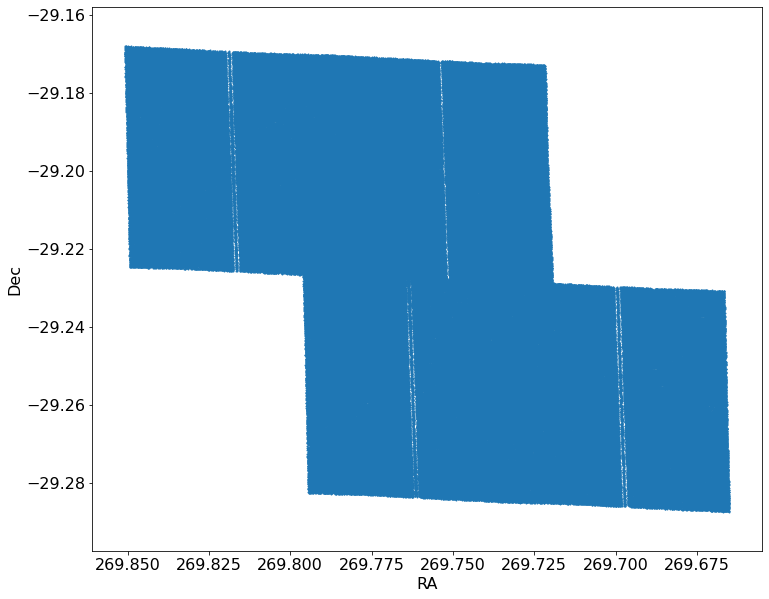

In [7]:
# tab = jobs.fast_table(DBtable, verbose=True)

x = tab['RA']
y = tab['Dec']

plt.rcParams.update({'font.size': 16})
#plt（matplotlib.pyplot）使用rc配置文件来自定义图形的各种默认属性，称之为rc配置或rc参数。
# 通过rc参数可以修改默认的属性，包括窗体大小、每英寸的点数、线条宽度、颜色、样式、坐标轴、坐标和网络属性、文本、字体等。
# rc参数存储在字典变量中，通过字典的方式进行访问。

plt.figure(1,(12,10))
plt.scatter(x, y, s=1)   # s为每个散点的面积
plt.autoscale(tight=True)   # autoscale函数可以切换是否自动缩放坐标轴范围;tight为布尔值，默认值为None，即是否设置边距为0，
plt.xlabel('RA')
plt.ylabel('Dec')
dc=0.01
plt.xlim(min(x)-dc, max(x)+dc)  # 作图范围
plt.ylim(min(y)-dc, max(y)+dc)  # 作图范围
plt.gca().invert_xaxis()        #plt.gca() : 'get current axes'
# 获取图像的轴，共有四个轴top、bottom、left和right;invert_xaxis()用于反转x轴。
plt.text(0.5,0.93,'{:,} stars in SWEEPS'.format(len(x)),horizontalalignment='left',transform=plt.gca.transAxes)
# plt.text()函数用于设置文字说明
# x,y:所添加标签的坐标值
# string:表示说明文字
# fontsize:表示字体大小
# verticalalignment：垂直对齐方式 ，参数：[ ‘center’ | ‘top’ | ‘bottom’ | ‘baseline’ ]
# horizontalalignment：水平对齐方式 ，参数：[ ‘center’ | ‘right’ | ‘left’ ]
# 变换坐标系：transform=plt.gca.transAxes

# Proper Motion Histograms <a class="anchor" id="pmhist"></a>

## Proper motion histograms for lon and lat

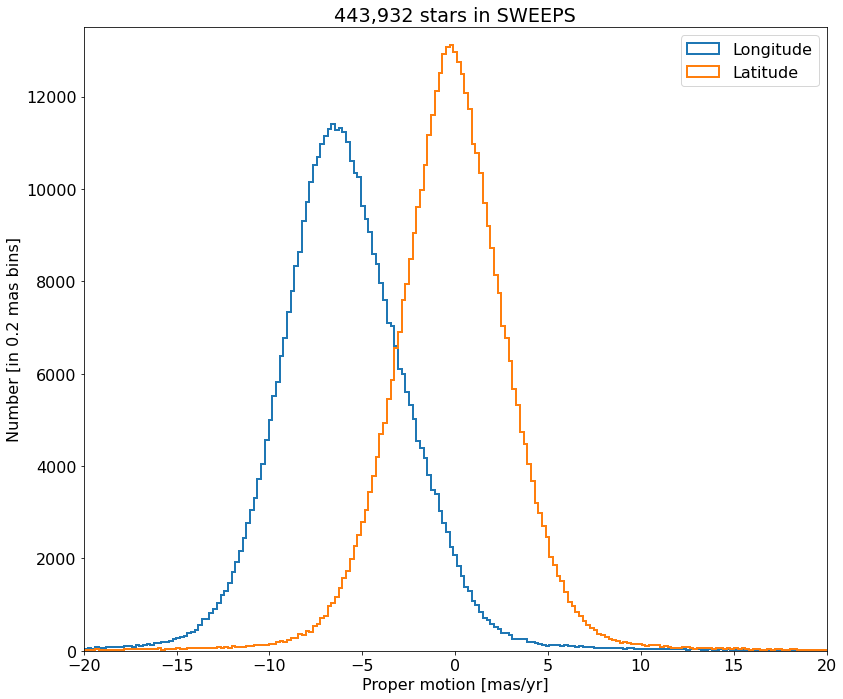

In [8]:
bin = 0.2
hrange = (-20,20)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1   # bincount = 201
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['lpm'], range=hrange, bins=bincount, label='Longitude',
           histtype='step', linewidth=2)
# range：元组或None；剔除较大和较小的离群值，给出全局范围；如果为None，则默认为(x.min(), x.max())；即x轴的范围
# bins: 要分的组数
# histtype：{‘bar’, ‘barstacked’, ‘step’, ‘stepfilled’}；'bar’是传统的条形直方图；'barstacked’是堆叠的条形直方图；'step’是未填充的条形直方图，只有外边框；‘stepfilled’是有填充的直方图；当histtype取值为’step’或’stepfilled’，rwidth设置失效，即不能指定柱子之间的间隔，默认连接在一起
plt.hist(tab['bpm'], range=hrange, bins=bincount, label='Latitude',
           histtype='step', linewidth=2)
plt.xlabel('Proper motion [mas/yr]')
plt.ylabel('Number [in {:.2} mas bins]'.format(bin))
plt.legend(loc='upper right')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,13500)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_pmerr_hist.png'.format(resPath))

## Proper motion error cumulative histogram for lon and lat

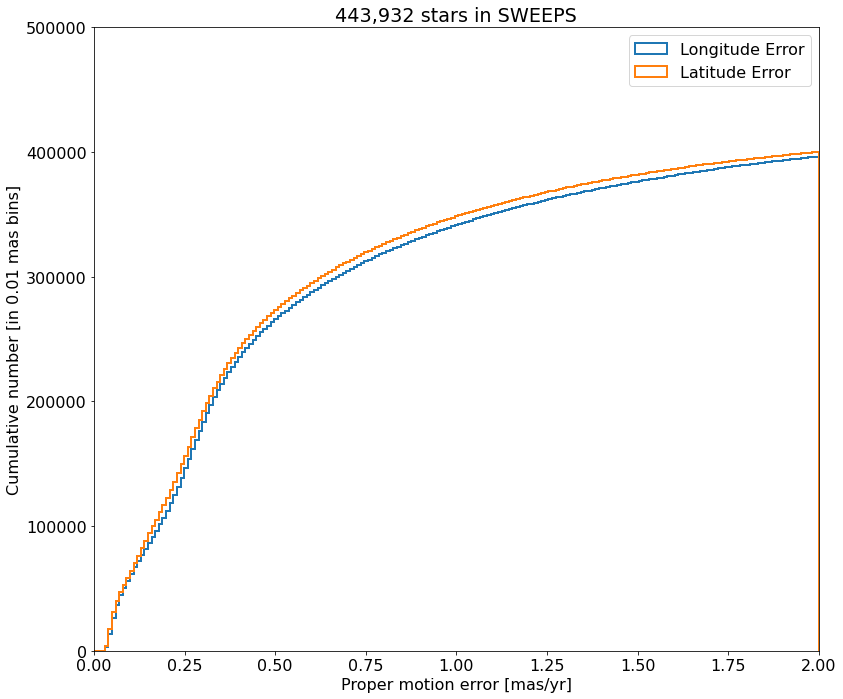

In [9]:
bin = 0.01
hrange = (0,2)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['lpmerr'], range=hrange, bins=bincount, label='Longitude Error',
           histtype='step', cumulative=1, linewidth=2)
plt.hist(tab['bpmerr'], range=hrange, bins=bincount, label='Latitude Error',
           histtype='step', cumulative=1, linewidth=2)
plt.xlabel('Proper motion error [mas/yr]')
plt.ylabel('Cumulative number [in {:0.2} mas bins]'.format(bin))
plt.legend(loc='upper right')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,500000)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_pmerr_cumhist.png'.format(resPath))

## Proper motion error log histogram for lon and lat

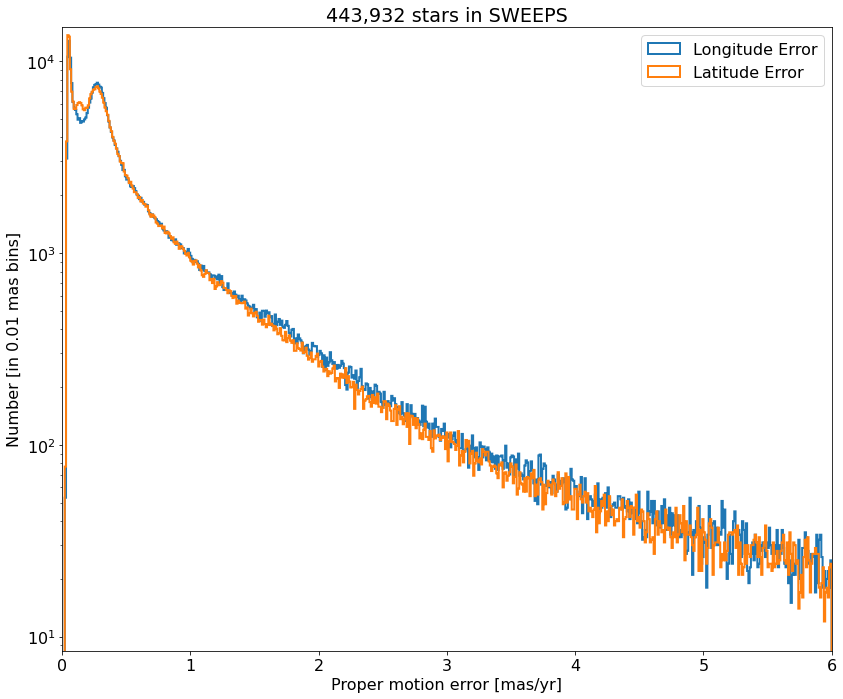

In [10]:
bin = 0.01
hrange = (0,6)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['lpmerr'], range=hrange, bins=bincount, label='Longitude Error',
           histtype='step', linewidth=2)
plt.hist(tab['bpmerr'], range=hrange, bins=bincount, label='Latitude Error',
           histtype='step', linewidth=2)
plt.xlabel('Proper motion error [mas/yr]')
plt.ylabel('Number [in {:0.2} mas bins]'.format(bin))
plt.legend(loc='upper right')
plt.yscale('log')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,15000)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_pmerr_loghist.png'.format(resPath))

### Proper motion error as a function of dT

Exclude objects with dT near zero, and to improve the plotting add a bit of random noise to spread out the quanitized time values.

kde took 11.3 sec
Plotting 177810 of 442682 points


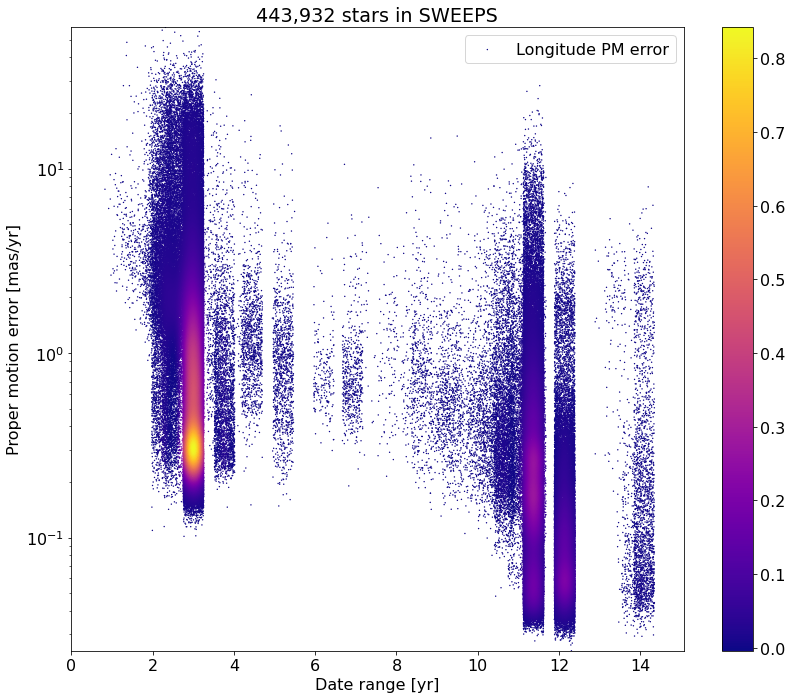

In [11]:
# restrict to sources with dT > 1 year
dtmin = 1.0
w = np.where(tab['dT']>dtmin)[0]
if ('rw' not in locals()) or len(rw) != len(w):  # locals() 函数会以字典类型返回当前位置的全部局部变量
    rw = np.random.random(len(w))
x = np.array(tab['dT'][w]) + 0.5*(rw-0.5)
y = np.log(np.array(tab['lpmerr'][w]))

# Calculate the point density
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**9+1)    # fastkde计算任意维数的核密度估计数据
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points插值获取z点值
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.yscale('log')
plt.scatter(xs, np.exp(ys), c=zs, s=2, edgecolor='none', cmap='plasma',
              label='Longitude PM error')
plt.autoscale(tight=True, axis='y')
plt.xlim(0.0, max(x)*1.05)
plt.xlabel('Date range [yr]')
plt.ylabel('Proper motion error [mas/yr]')
plt.legend(loc='best')
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.colorbar()
plt.tight_layout()
# plt.savefig('{}sweeps_pmerr_vs_dt.png'.format(resPath))

## Proper motion error log histogram for lon and lat

Divide sample into points with $<6$ years of data and points with more than 6 years of data.

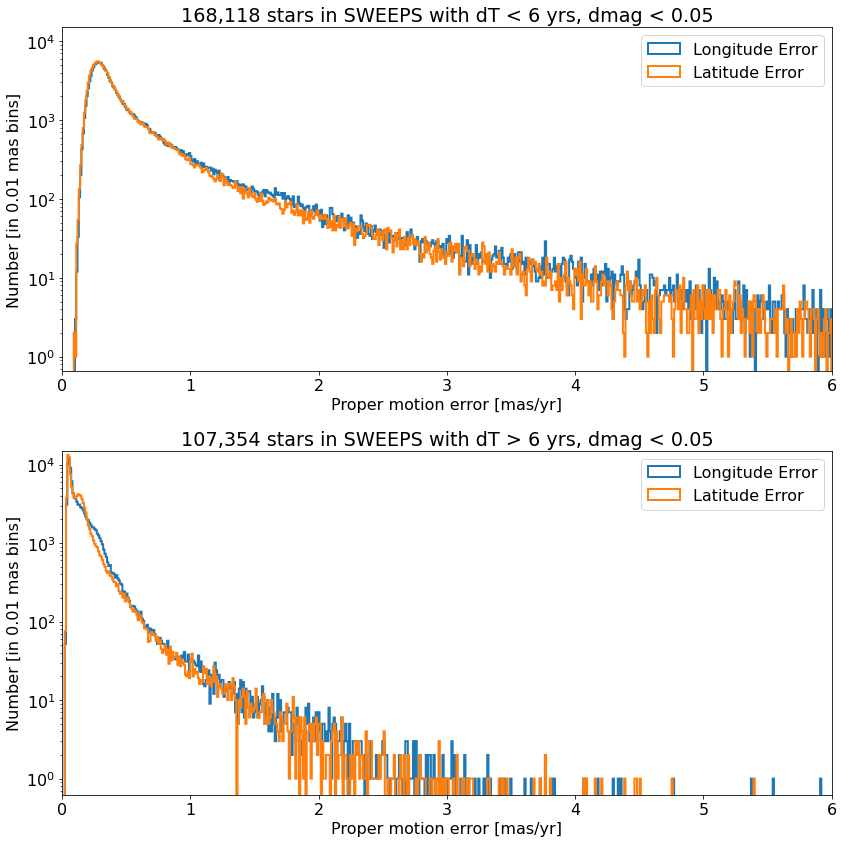

In [12]:
bin = 0.01
hrange = (0,6)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1

tsplit = 6
dmaglim = 0.05

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,12))

plt.subplot(211)
wmag = np.where((tab['a_f606w_mad']<dmaglim) & (tab['a_f814w_mad']<dmaglim))[0]
w = wmag[tab['dT'][wmag]<=tsplit]
plt.hist(tab['lpmerr'][w], range=hrange, bins=bincount, label='Longitude Error',
           histtype='step', linewidth=2)
plt.hist(tab['bpmerr'][w], range=hrange, bins=bincount, label='Latitude Error',
           histtype='step', linewidth=2)
plt.xlabel('Proper motion error [mas/yr]')
plt.ylabel('Number [in {:0.2} mas bins]'.format(bin))
plt.legend(loc='upper right')
plt.yscale('log')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,15000)
plt.title('{:,} stars in SWEEPS with dT < {} yrs, dmag < {}'.format(len(w),tsplit,dmaglim))
plt.tight_layout()

plt.subplot(212)
w = wmag[tab['dT'][wmag]>tsplit]
plt.hist(tab['lpmerr'][w], range=hrange, bins=bincount, label='Longitude Error',
           histtype='step', linewidth=2)
plt.hist(tab['bpmerr'][w], range=hrange, bins=bincount, label='Latitude Error',
           histtype='step', linewidth=2)
plt.xlabel('Proper motion error [mas/yr]')
plt.ylabel('Number [in {:0.2} mas bins]'.format(bin))
plt.legend(loc='upper right')
plt.yscale('log')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,15000)
plt.title('{:,} stars in SWEEPS with dT > {} yrs, dmag < {}'.format(len(w),tsplit,dmaglim))
plt.tight_layout()

plt.savefig('{}sweeps_pmerr_loghist2.png'.format(resPath))

# Number of Visits Histogram <a class="anchor" id="visitshist"></a>

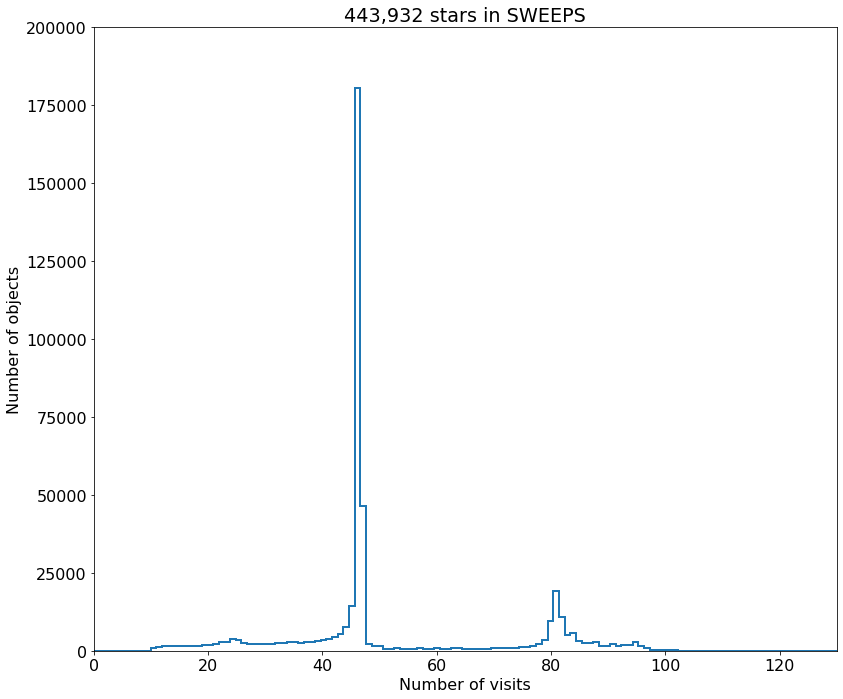

In [13]:
bin = 1
hrange = (0,130)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['NumVisits'], range=hrange, bins=bincount, label='Number of visits ',
           histtype='step', linewidth=2)
plt.xlabel('Number of visits')
plt.ylabel('Number of objects')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,200000)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_numvisits_hist.png'.format(resPath))

# Time Histograms <a class="anchor" id="timehist"></a>

First plot histogram of observation dates.

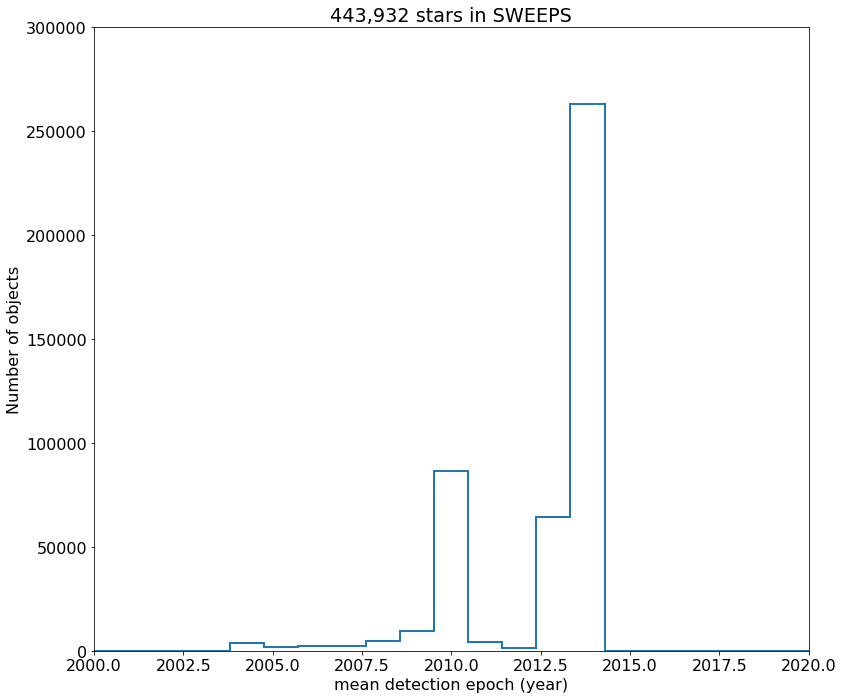

In [14]:
bin = 1
hrange = (2000, 2020)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))

plt.hist(tab['yr'], range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
plt.xlabel('mean detection epoch (year)')
plt.ylabel('Number of objects')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,300000)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
# plt.savefig('{}sweeps_year_hist.png'.format(resPath))

Then plot histogram of observation duration for the objects.

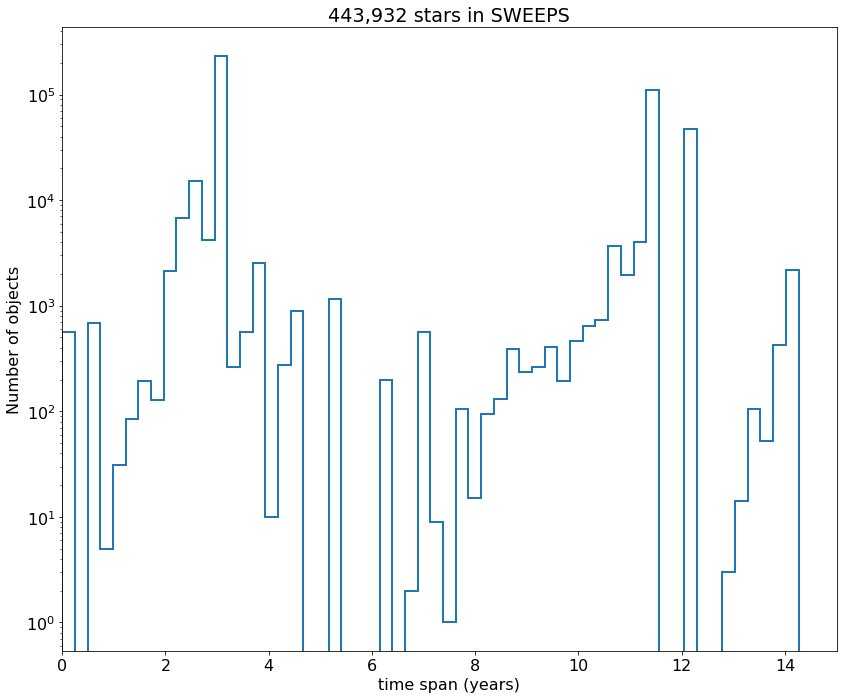

In [15]:
bin = 0.25
hrange = (0, 15)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['dT'], range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
plt.xlabel('time span (years)')
plt.ylabel('Number of objects')
plt.autoscale(enable=True, axis='x', tight=True)
plt.yscale('log')
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_year_hist.png'.format(resPath))

# Magnitude Histograms <a class="anchor" id="maghist"></a>

## Aper2 magnitude histograms for F606W and F814W

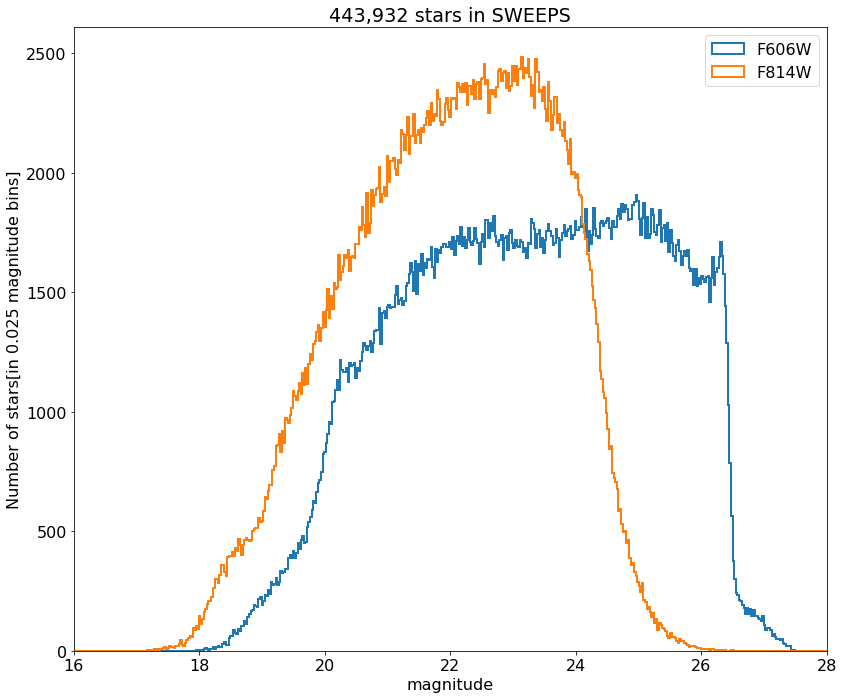

In [16]:
bin = 0.025
hrange = (16,28)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['a_f606w'], range=hrange, bins=bincount, label='F606W',
           histtype='step',  linewidth=2)
plt.hist(tab['a_f814w'], range=hrange, bins=bincount, label='F814W',
           histtype='step', linewidth=2)
plt.xlabel('magnitude')
plt.ylabel('Number of stars[in {:0.2} magnitude bins]'.format(bin))
plt.legend(loc='upper right')
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_mag_hist.png'.format(resPath))

## Aper2 magnitude error histograms for F606W and F814W

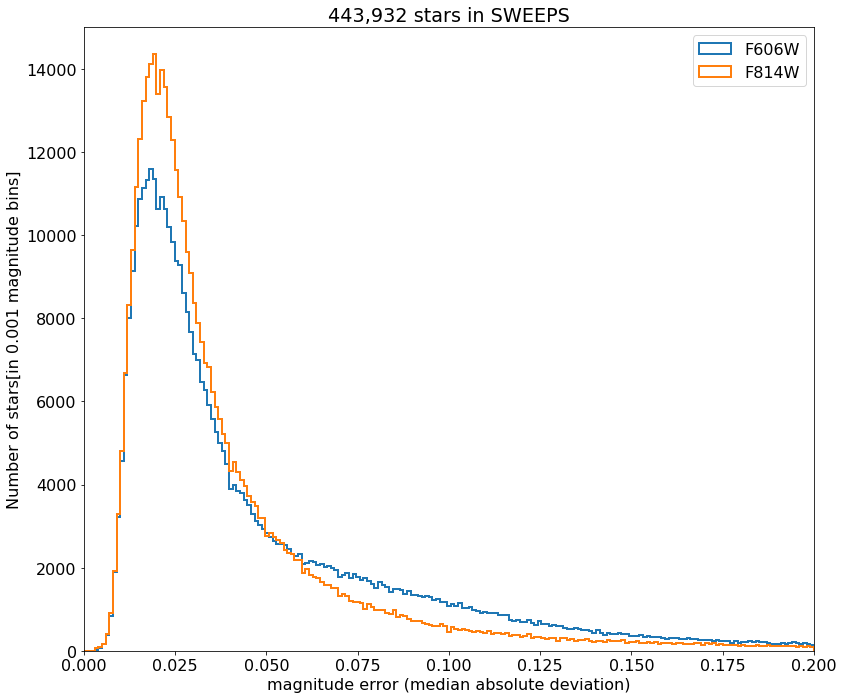

In [17]:
bin = 0.001
hrange = (0,0.2)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.hist(tab['a_f606w_mad'], range=hrange, bins=bincount, label='F606W',
           histtype='step',  linewidth=2)
plt.hist(tab['a_f814w_mad'], range=hrange, bins=bincount, label='F814W',
           histtype='step', linewidth=2)
plt.xlabel('magnitude error (median absolute deviation)')
plt.ylabel('Number of stars[in {:0.2} magnitude bins]'.format(bin))
plt.legend(loc='upper right')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0,15000)
plt.title('{:,} stars in SWEEPS'.format(len(tab)))
plt.tight_layout()
plt.savefig('{}sweeps_magerr_hist.png'.format(resPath))

# Color-Magnitude Diagram <a class="anchor" id="cmdall"></a>

## Color-magnitude diagram

Plot the color-magnitude diagram for the ~440k points retrieved from the database.  This uses fastkde to compute the kernel density estimate for the crowded plot, which is very fast. See https://pypi.org/project/fastkde/ for instructions -- or just do
<br />
<tt>pip install fastkde</tt>

kde took 13.2 sec
Plotting 147852 of 443502 points


Text(0.93, 0.93, '443,502 stars in SWEEPS')

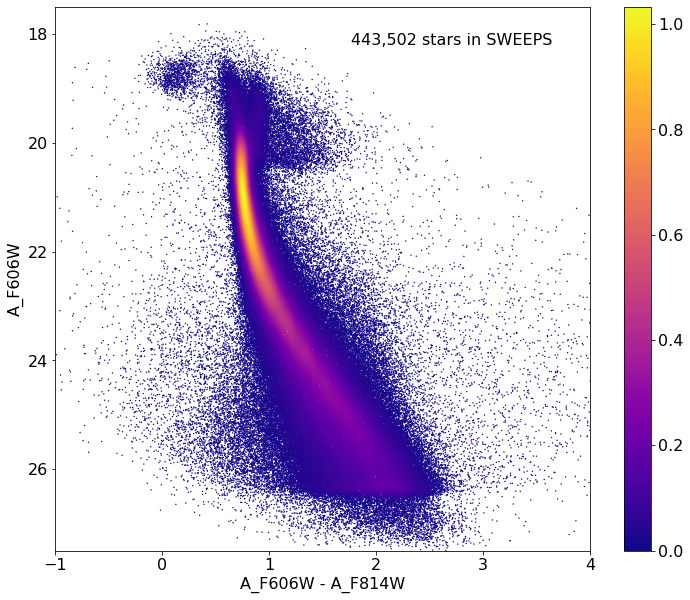

In [18]:
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w

# Calculate the point density
w = np.where((RminusI > -1) & (RminusI < 4))[0]
x = np.array(RminusI[w])
y = np.array(f606w[w])
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)

'''
估计输入数据核密度估计

输入：
var1 ：输入变量。
var2, var3... :附加输入变量，其长度
对应于 var1 的长度。随着输入变量的添加，生成的 PDF 的维度会增加（例如，提供 var1 和 var2 会导致 2D PDF）。
**kwargs :任何额外的关键字参数都直接传递给

返回：
pdf,axes ： 密度值pdf 和 PDF 的轴（即，这是类似于 hist,bins 的直方图）。
如果有多个输入变量，则坐标轴变量是坐标轴列表，每个坐标轴对应一个输入变量。
'''
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)   #建立插值函数:利用原始数据中有限的点，及其得到的密度值进行插值
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()   # argsort()对数据进行从小到大进行排序，返回数据的索引值
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]        # 将密度较大处的点剔除一部分，以提高速度
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')   # edgecolors散点的边缘颜色
plt.autoscale(tight=True)
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.gca().invert_yaxis()
plt.xlim(-1,4)
plt.ylim(27.5,17.5)
plt.colorbar()
plt.text(.93,.93,'{:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='right',
       transform=plt.gca().transAxes)
# plt.savefig("{}sweeps_colormag1.png".format(resPath))

# Detection Positions <a class="anchor" id="detpos"></a>

Define a function to plot the PM fit for an object.

In [19]:
# define function
def positions(Obj, jobs=None):
    """
    input parameter Obj is the value of the ObjID
    optional jobs parameter re-uses casjobs jobs variable
    output plots change in (lon, lat) as a function of time
    overplots proper motion fit
    provides number of objects and magnitude/color information
    输出坐标随时间变化，拟合其自行
    """
    if not jobs:
        jobs = mastcasjobs.MastCasJobs(context=HSCContext)

    # execute these as "system" queries so they don't fill up your Casjobs history

    # get the measured positions as a function of time
    query = """SELECT dT, dLon, dLat
        from AstromSourcePositions where ObjID={}
        order by dT
        """.format(Obj)
    pos = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                     astropy=True, system=True)
    # pos：银经，银纬，时间变化量，并且以时间排序

    '''
    def quick(self,
          q: Any,
          context: Any = None,
          task_name: str = "quickie",
          system: bool = False,
          astropy: bool = True) -> Optional[Generator]
    运行一个快速的进程。与 CasJobs 方法类似，但添加了 astropy 选项。

    ## 参数：
    q (str)：SQL 查询。
    ## 关键字参数
    context (str)：用于此查询的 Casjobs 内容
    task_name (str)：任务名称。
    system (bool) : 是否将此进程作为系统进程运行（在 Web UI 或历史记录中不可见）
    astropy (bool) : 如果为真，则返回输出为 astropy.Table

    ## 返回：
    results (str)：作为长字符串的作业结果（如果 astropy=True，则为 Table）。
    '''

    # get the PM fit parameters
    query = """SELECT pmlon, pmlonerr, pmlat, pmlaterr
        from AstromProperMotions where ObjID={}
        """.format(Obj)
    pm = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                    astropy=True, system=True)

    lpm = pm['pmlon'][0]
    bpm = pm['pmlat'][0]
    # get the intercept for the proper motion fit referenced to the start time
    # time between mean epoch and zero (ref) epoch (years)

    # get median magnitudes and colors for labeling
    # 辐射信息
    query = """SELECT a_f606w=i1.MagMed, a_f606_m_f814w=i1.MagMed-i2.MagMed
        from AstromSumMagAper2 i1
        join AstromSumMagAper2 i2 on i1.ObjID=i2.ObjID
        where i1.ObjID={} and i1.filter='f606w' and i2.filter='f814w'
        """.format(Obj)
    phot = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                      astropy=True, system=True)
    f606w = phot['a_f606w'][0]
    f606wmf814w = phot['a_f606_m_f814w'][0]

    x = pos['dT']
    y = pos['dLon']
    plt.rcParams.update({'font.size':10})
    plt.figure(1,(6,3))
    plt.subplot(121)
    plt.scatter(x, y, s=10)   # 观测值散点图

    # x = pos['dT']
    # y = pos['dLon']
    xpm = np.array([x.min(),x.max()])       # 自行观测值的时间变量的最大值和最小值
    #lpm = pm['pmlon'][0]
    ypm = lpm*xpm           # lpm = pm['pmlon'][0]
    plt.plot(xpm, ypm, '-r')
    plt.xlabel('dT (yrs)')
    plt.ylabel('dLon (mas)')

    # 图二绘制赤纬的变化情况
    y = pos['dLat']
    plt.subplot(122)
    plt.scatter(x, y, s=10)
    ypm = bpm*xpm
    plt.plot(xpm, ypm, '-r')
    plt.xlabel('dT (yrs)')
    plt.ylabel('dLat (mas)')
    plt.suptitle("""ObjID {0}
{1} detections,  (lpm, bpm) = ({2:.1f}, {3:.1f}) mas/yr
(f606w, f606w-f814w) = ({4:.1f}, {5:.1f})""".format(Obj, len(x), lpm, bpm, f606w, f606wmf814w),
                  size=10)
    plt.tight_layout(rect=[0, 0.0, 1, 0.88])
    plt.show()
    plt.close()

## Plot positions of objects that are detected in more than 90 visits with a median absolute deviation from the fit of less than 1.5 mas and proper motion error less than 1.0 mas/yr.

Plotting 21 objects


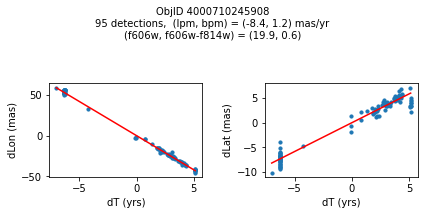

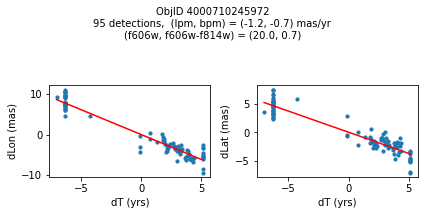

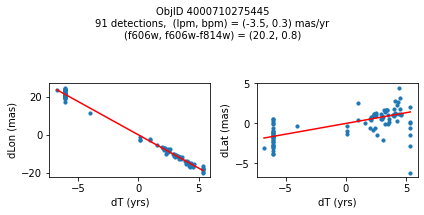

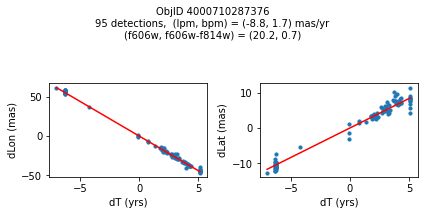

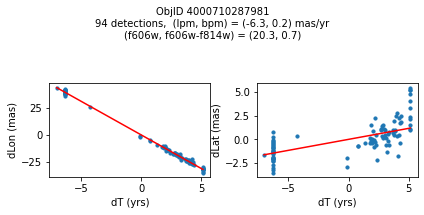

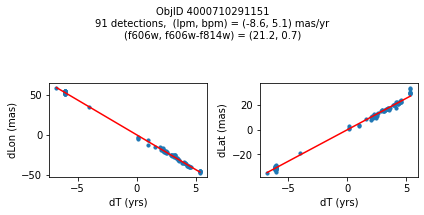

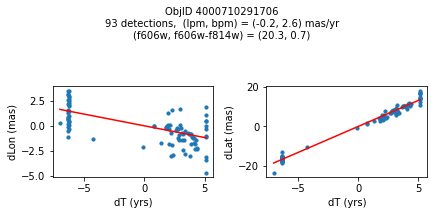

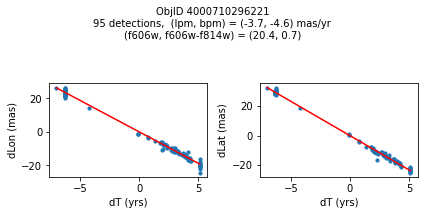

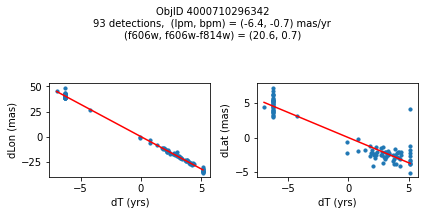

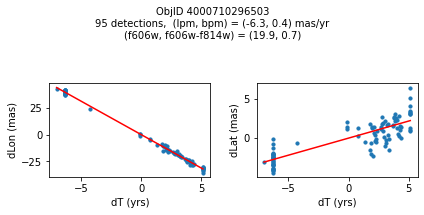

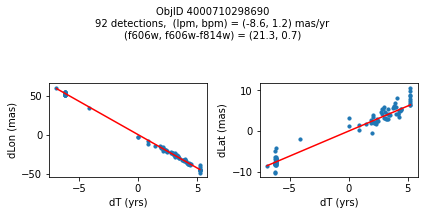

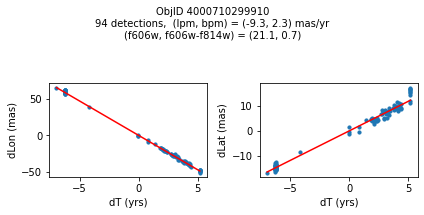

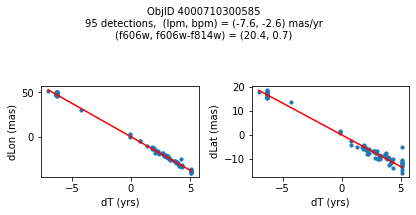

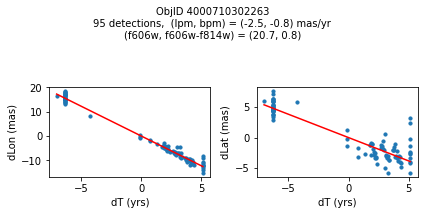

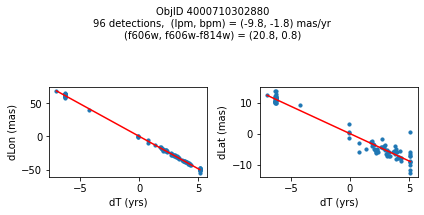

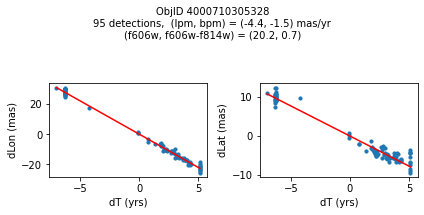

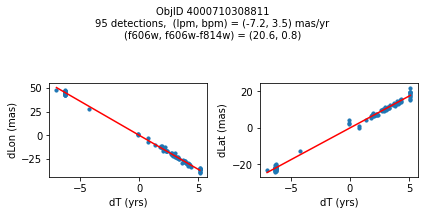

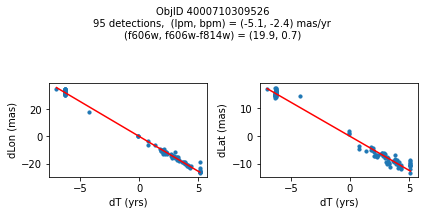

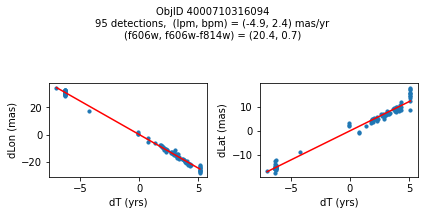

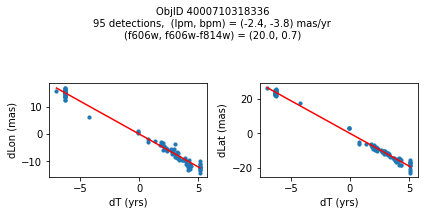

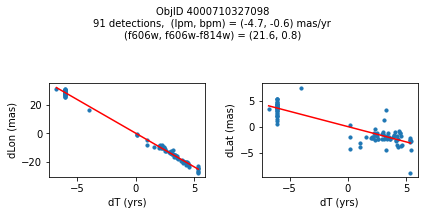

In [20]:
n = tab['NumVisits']
dev = tab['pmdev']
objid = tab['ObjID']
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
wi = np.where( (dev < 1.5) & (n > 90) & (np.sqrt(bpmerr0**2+lpmerr0**2) < 1.0))[0]  #筛选条件：dev < 1.5，n > 90，合成的自行矢量小于1
print("Plotting {} objects".format(len(wi)))
for o in objid[wi]:
    positions(o, jobs=jobs)

# Good Photometric Objects <a class="anchor" id="goodphot"></a>

## Look at photometric error distribution to pick out good photometry objects as a function of magnitude <a class="anchor" id="gooderrs"></a>

The photometric error is mainly a function of magnitude.  We make a cut slightly above the typical error to exclude objects that have poor photometry.  (In the SWEEPS field, that most often is the result of blending and crowding.)

Plotting 274227 of 443502 points
23.4 s: completed kde
Plotting 250585 of 443502 points


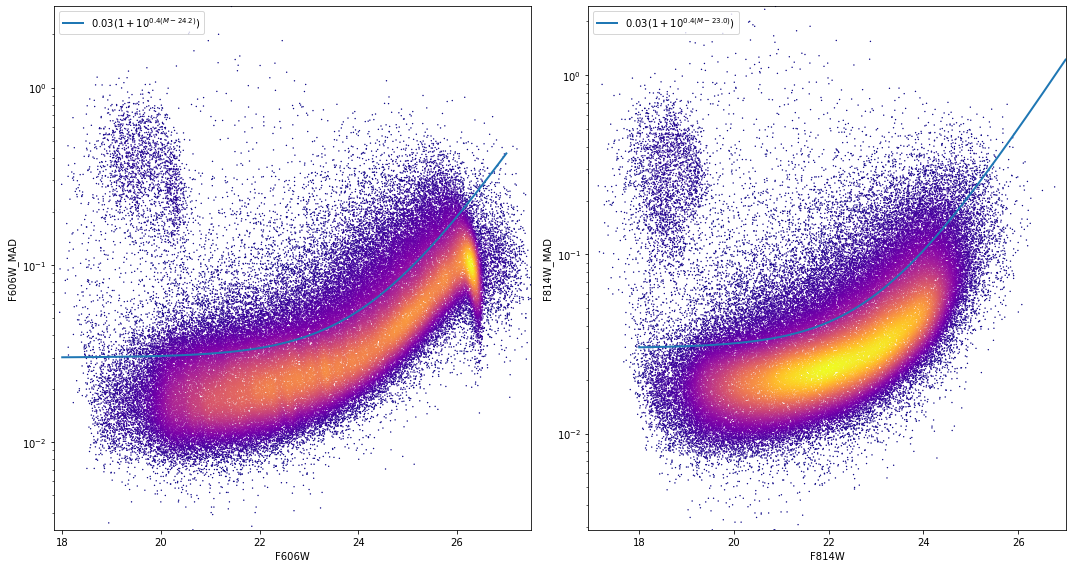

In [21]:
# 查看光度误差分布以挑选出良好的光度测量对象作为星等的函数
# 做一个略高于典型误差的切割，以排除光度差的物体,SWEEPS ，这通常是混合和拥挤的结果
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w

w = np.where((RminusI > -1) & (RminusI < 4))[0]
f606w_mad = tab['a_f606w_mad']
f814w_mad = tab['a_f814w_mad']

t0=time.time()
# Calculate the point density
x1 = np.array(f606w[w])
y1 = np.array(f606w_mad[w])
y1log = np.log(y1)
myPDF1,axes1 = fastKDE.pdf(x1,y1log,numPoints=2**10+1)
finterp = RectBivariateSpline(axes1[1],axes1[0],myPDF1)
z1 = finterp(y1log,x1,grid=False)   # z1即用插值方法得到的全域密度值的集合
'''
由此，得到点 (x_1,y1) 处的密度值 z1
'''

# Sort the points by density, so that the densest points are plotted last
idx = z1.argsort()
xs1, ys1, zs1 = x1[idx], y1[idx], z1[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs1))*zs1<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs1)))
xs1 = xs1[wran]
ys1 = ys1[wran]
zs1 = zs1[wran]
'''
经排序、随机剔除后的点（xs1,ys1）以及对应的密度值 zs1
x1 = np.array(f606w[w])
y1 = np.array(f606w_mad[w])
'''


'''
以下处理方式相同，只是针对f814
最终得到（xs2,ys2）以及对应的密度值 zs2
'''
x2 = np.array(f814w[w])
y2 = np.array(f814w_mad[w])
y2log = np.log(y2)
myPDF2,axes2 = fastKDE.pdf(x2,y2log,numPoints=2**10+1)
finterp = RectBivariateSpline(axes2[1],axes2[0],myPDF2)
z2 = finterp(y2log,x2,grid=False)
idx = z2.argsort()
xs2, ys2, zs2 = x2[idx], y2[idx], z2[idx]
print("{:.1f} s: completed kde".format(time.time()-t0))

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs2))*zs2<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs2)))
xs2 = xs2[wran]
ys2 = ys2[wran]
zs2 = zs2[wran]

######################################################################################

xr = (18,27)
xx = np.arange(501)*(xr[1]-xr[0])/500.0 + xr[0]   # np.arange(501)*(27-18)/500 + 18
xcut1 = 24.2
xnorm1 = 0.03
xcut2 = 23.0
xnorm2 = 0.03

# only plot a subset of the points to speed things up
qsel = 3
xs1 = xs1[::qsel]
ys1 = ys1[::qsel]
zs1 = zs1[::qsel]
xs2 = xs2[::qsel]
ys2 = ys2[::qsel]
zs2 = zs2[::qsel]
'''
x1 : f606w
y1 : f606w_mad
'''

# to 122
plt.figure(1,(15,8))
plt.subplot(121)
plt.yscale('log')
plt.scatter(xs1,ys1,c=zs1,s=2,edgecolor='none',cmap='plasma')
plt.autoscale(tight=True)
# overplot an error limit that varies with magnitude of the form listed below
plt.plot(xx,xnorm1 * (1. + 10.**(0.4*(xx-xcut1))),linewidth=2.0,
           label='$%.2f (1+10^{0.4(M-%.1f)})$' % (xnorm1,xcut1))
plt.legend(loc='upper left')
plt.xlabel('F606W')
plt.ylabel('F606W_MAD')
'''
xr = (18,27)
xx = np.arange(501)*(xr[1]-xr[0])/500.0 + xr[0]
xcut1 = 24.2
xnorm1 = 0.03
xcut2 = 23.0
xnorm2 = 0.03
'''


# to 122
plt.subplot(122)
plt.yscale('log')
plt.scatter(xs2,ys2,c=zs2,s=2,edgecolor='none',cmap='plasma')
plt.autoscale(tight=True)
# overplot an error limit that varies with magnitude of the form listed below
plt.plot(xx,xnorm2 * (1. + 10.**(0.4*(xx-xcut2))),linewidth=2.0,
           label='$%.2f (1+10^{0.4(M-%.1f)})$' % (xnorm2,xcut2))
plt.legend(loc='upper left')
plt.xlabel('F814W')
plt.ylabel('F814W_MAD')
plt.tight_layout()

## Define function to apply noise cut and plot color-magnitude diagram with cut
Note that we reduce the R-I range to 0-3 here because there are very few objects left bluer than R-I = 0 or redder than R-I = 3.

kde took 8.5 sec
Plotting 129757 of 333525 points


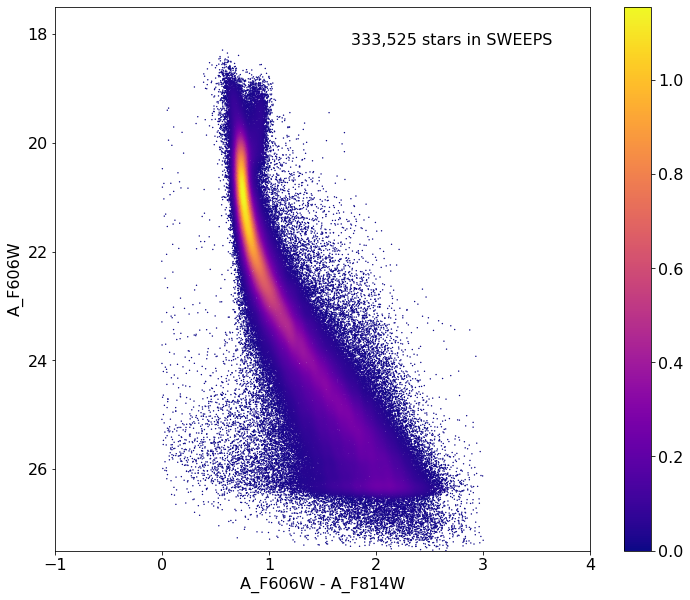

In [22]:
# 定义函数以降噪并绘制有cut的颜色-星等图
# 将 R-I 范围减少到 (0,3)，因为很少有目标比 R-I = 0 更蓝或比 R-I = 3 更红。
def noisecut(tab, factor=1.0):
    """Return boolean array with noise cut in f606w and f814w using model
    factor is normalization factor to use (>1 means allow more noise)
    在 f606w 和 f814w 中使用模型,
    返回具有降噪功能的布尔数组
    要使用的归一化因子（>1 表示允许更多噪声)
    """

    '''
    以恒星的星等为标准，计算这个亮度的恒星对应的最大绝对中位差,若超过限度将返回一个False
    factor可以对这个限度做微调
    '''
    f606w = tab['a_f606w']
    f814w = tab['a_f814w']
    f606w_mad = tab['a_f606w_mad']
    f814w_mad = tab['a_f814w_mad']

    # noise model computed above
    xcut_f606w = 24.2
    xnorm_f606w = 0.03 * factor
    xcut_f814w = 23.0
    xnorm_f814w = 0.03 * factor
    return ((f606w_mad < xnorm_f606w*(1+10.0**(0.4*(f606w-xcut_f606w))))
          & (f814w_mad < xnorm_f814w*(1+10.0**(0.4*(f814w-xcut_f814w))))
           )

# low-noise objects
good = noisecut(tab,factor=1.0)     # 对数据集全体使用 noisecut(),返回布尔数组

# Calculate the point density
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]   # 通过三次真值运算(颜色在0-3之间，且经过降噪处理)获得被筛选数值的布尔索引
x = np.array(RminusI[w])     # 根据布尔索引w筛选数值
y = np.array(f606w[w])       # 根据布尔索引w筛选数值
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)     #密度估计
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)     # 利用插值将有限点的密度扩展到平面内所有点的密度，z=f(x,y)


# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
# 利用随机数产生器，随机剔除一部部高密度区域的点，提高绘图速度
wran = np.where(np.random.random(len(zs))*zs<0.075)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.gca().invert_yaxis()
plt.xlim(-1,4)
plt.ylim(27.5,17.5)
plt.colorbar()
plt.text(.93,.93,'{:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='right',
       transform=plt.gca().transAxes)
plt.savefig("{}sweeps_colormag2.png".format(resPath))

# Science Applications <a class="anchor" id="sciap"></a>

# Proper Motions of Good Objects <a class="anchor" id="goodpm"></a>

## Average proper motion in color-magnitude bins

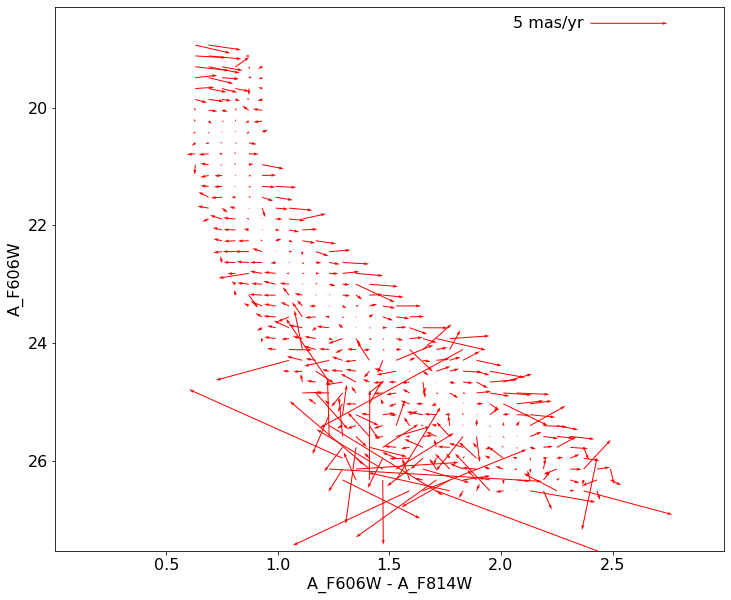

In [23]:
# good defined above
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]        # 通过三次真值运算获得被筛选数值的布尔索引
# 筛选坐标相关数据
lpm = np.array(tab['lpm'][w])       # 筛选lpm
bpm = np.array(tab['bpm'][w])       # 筛选bpm

# 筛选辐射相关数据
x = np.array(RminusI[w])
y = np.array(f606w[w])

nbins = 50


count2d, yedge, xedge = np.histogram2d(y, x, bins=nbins)                                    # count2d.shape() = (50,50)

lpm_sum =               np.histogram2d(y, x, bins=nbins, weights=lpm-lpm.mean())[0]         # 仅获取直方图高度值，对每个样本(x_i, y_i)进行加权，偏离越大，权重越大
bpm_sum =               np.histogram2d(y, x, bins=nbins, weights=bpm-bpm.mean())[0]         # 仅获取直方图高度值，对每个样本(x_i, y_i)进行加权，偏离越大，权重越大
lpm_sumsq =             np.histogram2d(y, x, bins=nbins, weights=( lpm-lpm.mean() )**2)[0]  # 仅获取直方图高度值，权重是此处数值与平均bpm之差的平方
bpm_sumsq =             np.histogram2d(y, x, bins=nbins, weights=(bpm-bpm.mean())**2)[0]    # 仅获取直方图高度值，权重是此处数值与平均bpm之差的平方

'''
def histogram2d(x: Union[ndarray, Iterable, int, float],
                y: Union[ndarray, Iterable, int, float],
                bins: Any = 10,
                range: Union[ndarray, Iterable, int, float, None] = None,
                normed: Optional[bool] = None,
                weights: Union[ndarray, Iterable, int, float, None] = None,
                density: Optional[bool] = None) -> Any
计算两个数据样本的二维直方图。

参数：
x - 一个数组，包含要进行直方图的点的 x 坐标。
y – 一个数组，包含要进行直方图绘制的点的 y 坐标。
bins: *如果是 int，则为两个维度的 bin 数 (nx=ny=bins)。
      * 如果是 array_like，则为两个维度的 bin 边缘 (x_edges=y_edges=bins)。
      * 如果是[int, int]，每个维度的bin数（nx, ny = bins）。
      * 如果 [array, array]，则每个维度中的 bin 边缘 (x_edges, y_edges = bins)。
      * [int, array] 或 [array, int] 的组合，其中 int 是 bin 的数量，array 是 bin 的边缘。
range - 沿每个维度的 bin 最左边和最右边的边缘（如果没有在 `bins` 参数中明确指定）：`[[xmin, xmax], [ymin, ymax]]`。此范围之外的所有值都将被视为异常值，并且不计入直方图中。
normed – 行为相同的密度参数的别名。为避免与 `histogram` 的损坏规范参数混淆，应首选`density`
       如果“normed”为真，则权重被归一化为 1。
       如果 `normed` 为 False，则返回的直方图的值等于属于每个 bin 的样本的权重之和。
weights – 一组值 ``w_i`` 对每个样本 ``(x_i, y_i)`` 进行加权。
density -- 默认为 False，返回每个 bin 中的样本数。如果为真，则返回 bin 处的概率密度函数，``bin_count / sample_count / bin_area``。

按（x, y）做散点图，根据 bins[0], bins[1]，分别把x、y坐标切成若干等分。xedges，是bins[0] + 1 个值，最小是x的最小值，最大是x的最大值，中间的值是一个等差数列。yedges对照xedges理解。xedges、yegdes把散点图切成了N份，H是一个 bins[0]列、bins[1]行的数组，每个未知的值，是（x, y）散点图落在对应格子内的个数。
'''

ccount = count2d.clip(1)          # 最小为1
'''
numpy.clip(a, a_min, a_max, out=None)
参数:
a : 输入的数组
a_min: 限定的最小值 也可以是数组 如果为数组时 shape必须和a一样
a_max:限定的最大值 也可以是数组 shape和a一样
out：剪裁后的数组存入的数组

返回：
数组：输入数组中小于a_min的元素被替换为a_min，大于a_min的元素被替换为a_max
'''


lpm_mean = lpm_sum/ccount   #
bpm_mean = bpm_sum/ccount

lpm_rms = np.sqrt(lpm_sumsq/ccount-lpm_mean**2)     # RMS:Root Mean Square
bpm_rms = np.sqrt(bpm_sumsq/ccount-bpm_mean**2)

lpm_msigma = lpm_rms/np.sqrt(ccount)
bpm_msigma = bpm_rms/np.sqrt(ccount)

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
ww = np.where(count2d > 100)
yy, xx = np.mgrid[:nbins,:nbins]
'''
举例:
np.mgrid(start： end： step) #生成等差数组，[start： end)闭包关系

res = np.mgrid[-3:3:.1,-3:3:.1]
生成从-3到3的二维坐标
第一部分是y轴的范围
第二部分是x轴的范围
返回数组的res[0]是y轴，res[1]是x轴
'''

xx = (0.5*(xedge[1:]+xedge[:-1]))[xx]
yy = (0.5*(yedge[1:]+yedge[:-1]))[yy]
# plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
Q = plt.quiver(xx[ww],yy[ww],lpm_mean[ww],bpm_mean[ww],color='red',width=0.0015)
'''
quiver(X, Y, U, V, C, **kw)
参数：
X 和 Y 是箭头的 x 和 y 坐标（默认是箭头的尾部）
U 和 V  是箭头矢量的 x 和 y 分量
C 是映射箭头和颜色的颜色数组

几个常见的参数：
units： 此参数指示了除箭头长度外，其他尺寸的变化趋势，以该单位的倍数测量。可取值为 {'width', 'height', 'dots', 'inches', 'x', 'y' 'xy'}, 默认是 'width'。需要配合 scale 参数使用。
scale: float, optional。此参数是每个箭头长度单位的数据单位数，通常该值越小，意味着箭头越长，默认为 None ,此时系统会采用自动缩放算法。箭头长度单位由 scale_units 参数指定。
scale_units: 此参数是可选参数，其中包含以下值：{'width', 'height', 'dots', 'inches', 'x', 'y', 'xy'}, 一般当 scale=None 时该选项指示长度单位，默认为 None。
angles: 此参数指定了确定箭头角度的方法，可以取 {'uv', 'xy'} 或者 array-like, 默认是 'uv'。 设计原因是 因为图的宽和高可能不同，所以 x 方向的单位长度和 y 方向的单位长度可能不同，这时我们需要做出选择，一是不管长度对不对，角度一定要对，此时 angles='uv'，二是不管角度了，只要长度对就可以了，此时 angles='xy'。当该值为一个 array 的时候，该数组应该是以度数为单位的数组，表示了每一个箭头的方向
'''

qlength = 5
plt.quiverkey(Q,0.8,0.97,qlength,'{} mas/yr'.format(qlength),coordinates='axes',labelpos='W')
plt.gca().invert_yaxis()
plt.autoscale(tight=True)
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[-1],yedge[0]))
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
# plt.savefig('{}sweeps_vecmean.png'.format(resPath))

## RMS in longitude PM as a function of color/magnitude

# Mean longitude PM as image

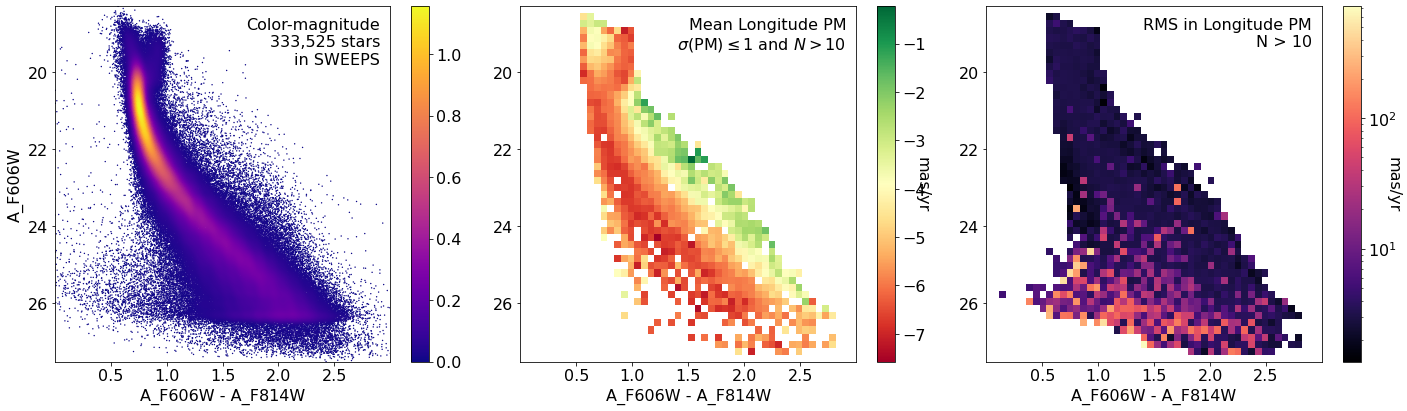

In [24]:
# 均方根RMS
plt.rcParams.update({'font.size': 16})
plt.figure(1,(20,6))


sub1 = plt.subplot(131)
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.text(0.97, 0.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
plt.colorbar()



sub2 = plt.subplot(132)
plt.xlim((xedge[0],xedge[-1]))      # count2d, yedge, xedge = np.histogram2d(y, x, bins=nbins)
plt.ylim((yedge[0],yedge[-1]))
mask = (lpm_msigma <= 1.0) & (count2d > 10)
im = (lpm_mean+lpm.mean())*mask # 选取lpm_mean，条件为上一行代码所给,Flase处的值将为0
im[~mask] = np.nan          # ~进行取反，nan表示not a number
vmax = np.nanmax(np.abs(im))        # np.nanmax()：可以将np.nan排除进行最大值的计算，并得到想要的正确结果
plt.imshow(im,cmap='RdYlGn',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]))
# aspect用于指定热图的单元格的大小，默认值为equal,此时单元格用于是一个方块，当设置为auto时，会根据画布的大小动态调整单元格的大小
# extent参数指定热图x轴和y轴的极值，取值为一个长度为4的元组或列表，其中，前两个数值对应x轴的最小值和最大值，后两个参数对应y轴的最小值和最大值
# orign参数指定绘制热图时的方向，默认值为upper,  此时热图的右上角为(0, 0), 当设置为lower时，热图的左下角为(0,0)
plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.text(0.97, 0.97,'Mean Longitude PM\n$\sigma(\mathrm{PM}) \leq 1$ and $N > 10$',
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
cbar = plt.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)



sub2 = plt.subplot(133)
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
# lpm_rms = np.sqrt(lpm_sumsq/ccount-lpm_mean**2)
im = lpm_rms*(count2d>10)           # count2d, yedge, xedge = np.histogram2d(y, x, bins=nbins)
plt.imshow(im,cmap='magma',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]),
            norm=LogNorm(vmin=im[im>0].min(), vmax=im.max()))


plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.text(0.97, 0.97,'RMS in Longitude PM\nN > 10',
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
cbar = plt.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

plt.tight_layout()
plt.savefig("{}sweeps_PMlon.png".format(resPath))

## Mean latitude PM as image

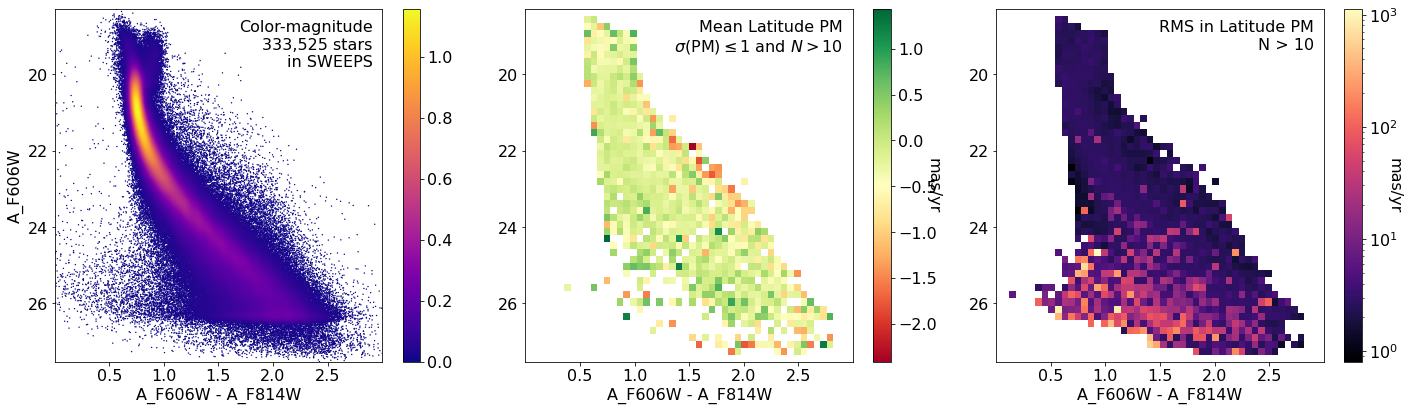

In [25]:
# 实现方式同“Mean latitude PM as image”
plt.rcParams.update({'font.size': 16})
plt.figure(1,(20,6))

sub1 = plt.subplot(131)
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.text(0.97,0.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
plt.colorbar()

sub2 = plt.subplot(132)
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
mask = (bpm_msigma <= 1.0) & (count2d > 10)
im = (bpm_mean+bpm.mean())*mask
im[~mask] = np.nan
vmax = np.nanmax(np.abs(im))
plt.imshow(im,cmap='RdYlGn',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.text(.97,.97,'Mean Latitude PM\n$\sigma(\mathrm{PM}) \leq 1$ and $N > 10$',
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
cbar = plt.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

sub2 = plt.subplot(133)
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
im = bpm_rms*(count2d>10)
plt.imshow(im,cmap='magma',aspect="auto",origin="lower",        #RMS》10
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]),
            norm=LogNorm(vmin=im[im>0].min(), vmax=im.max()))
plt.gca().invert_yaxis()
plt.xlabel('A_F606W - A_F814W')
plt.text(.97,.97,'RMS in Latitude PM\nN > 10',
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
cbar = plt.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

plt.tight_layout()
plt.savefig("{}sweeps_PMlat.png".format(resPath))

# Proper Motions in Bulge and Disk <a class="anchor" id="bulgedisk"></a>

## Fit a smooth function to the main ridgeline of color-magnitude diagram
Fit the R-I vs R values, but force the function to increase montonically with R.  We use a log transform of the y coordinate to help.

In [26]:
# 核球和银盘
# 将平滑函数拟合到颜色-星等图的主脊线
# 拟合 R-I 与 R 值，使用 y 坐标的对数变换，使函数随R单调增加

# locate ridge line
iridgex = np.argmax(myPDF,axis=1)       # 得到了每一行密度最大处的索引值
# argmax()是numpy中获取array的各维度中数值最大元素的索引，axis=1为横向，axis=0为纵向
pdfx = myPDF[np.arange(len(iridgex),dtype=int),iridgex]
# pdfx = myPDF.max(axis=1)
wx = np.where(pdfx > 0.1)[0]
iridgex = iridgex[wx]
# use weighted sum of 2*hw+1 points around peak
hw = 10
pridgex = 0.0
pdenom = 0.0
for k in range(-hw,hw+1):
    wt = myPDF[wx,iridgex+k]
    pridgex = pridgex + k*wt
    pdenom = pdenom + wt
pridgex = iridgex + pridgex/pdenom
ridgex = np.interp(pridgex, np.arange(len(axes[0])), axes[0])

# Fit the data using a polynomial model
x0 = axes[1][wx].min()
x1 = axes[1][wx].max()
p_init = models.Polynomial1D(9)
fit_p = fitting.LinearLSQFitter()
xx = (axes[1][wx]-x0)/(x1-x0)
yoff = 0.65
yy = np.log(ridgex - yoff)
p = fit_p(p_init, xx, yy)

# define useful functions for the ridge line

def ridge_color(f606w, function=p, yoff=yoff, x0=x0, x1=x1):
    """Return R-I position of ridge line as a function of f606w magnitude

    function, yoff, x0, x1 are from polynomial fit above
    """
    return yoff + np.exp(p((f606w-x0)/(x1-x0)))

# calculate grid of function values for approximate inversion
rxgrid = axes[1][wx]
rygrid = ridge_color(rxgrid)
color_domain = [rygrid[0],rygrid[-1]]
mag_domain = [axes[1][wx[0]], axes[1][wx[-1]]]
print("color_domain {}".format(color_domain))
print("mag_domain   {}".format(mag_domain))

def ridge_mag(RminusI, xgrid=rxgrid, ygrid=rygrid):
    """Return f606w position of ridge line as a function of R-I color
    Uses simple linear interpolation to get approximate value
    """
    f606w = np.interp(RminusI,ygrid,xgrid)
    f606w[(RminusI < ygrid[0]) | (RminusI > ygrid[-1])] = np.nan
    return f606w

color_domain [0.6883374859495942, 2.1560516758348167]
mag_domain   [19.356585323810577, 26.480549454689026]


In [27]:
np.shape(iridgex)

(396,)

In [28]:
np.shape(myPDF)

(1025, 1025)

Plot the results to check that they look reasonable.

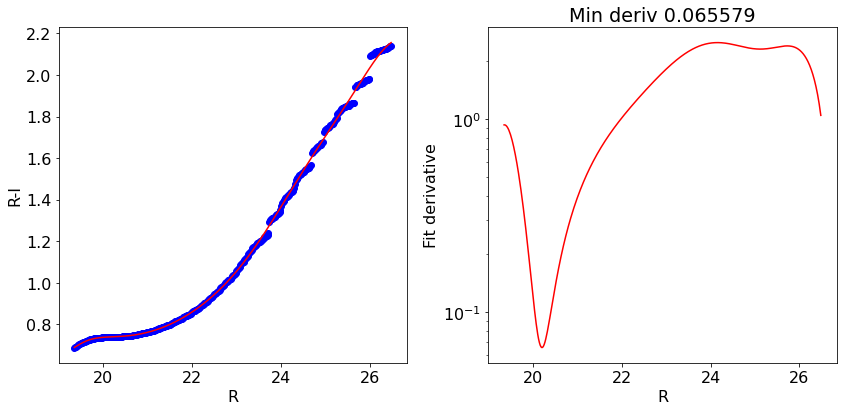

In [29]:
ridgexf = yoff + np.exp(p(xx))

plt.figure(1,(12,6))
plt.subplot(121)
plt.plot(axes[1][wx], ridgex, 'bo')
plt.plot(axes[1][wx], ridgexf, color='red')
plt.ylabel('R-I')
plt.xlabel('R')

# check the derivative plot to see if it stays positive
deriv = np.exp(p(xx))*models.Polynomial1D.horner(xx,
                            (p.parameters * np.arange(len(p.parameters)))[1:])
plt.subplot(122)
plt.semilogy(axes[1][wx], np.exp(p(xx))*models.Polynomial1D.horner(xx,
                            (p.parameters * np.arange(len(p.parameters)))[1:]),color='red')
plt.xlabel('R')
plt.ylabel('Fit derivative')
plt.title('Min deriv {:.6f}'.format(deriv.min()))
plt.tight_layout()

## Plot the ridgeline on the CMD

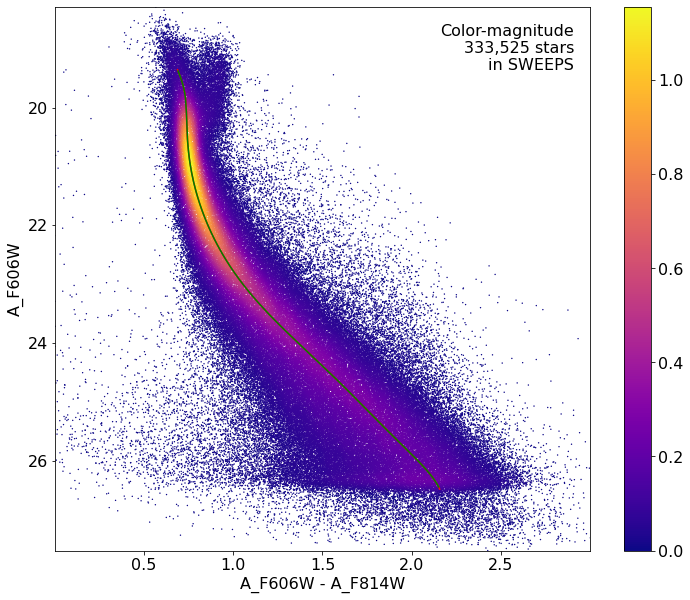

In [30]:
plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()

# overplot ridge line
plt.plot(ridge_color(axes[1][wx]), axes[1][wx], color='red')
plt.plot(axes[0], ridge_mag(axes[0]), color='green')

plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.text(.97,.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
plt.colorbar()
# plt.savefig('{}sweeps_ridgeline.png'.format(resPath))

## Binned distribution of PM(Long) vs magnitude offset from ridge line

1.0020693112164736 23.78496902411135 1.0020693112164736 20.78496902411135
(394,) (394,)


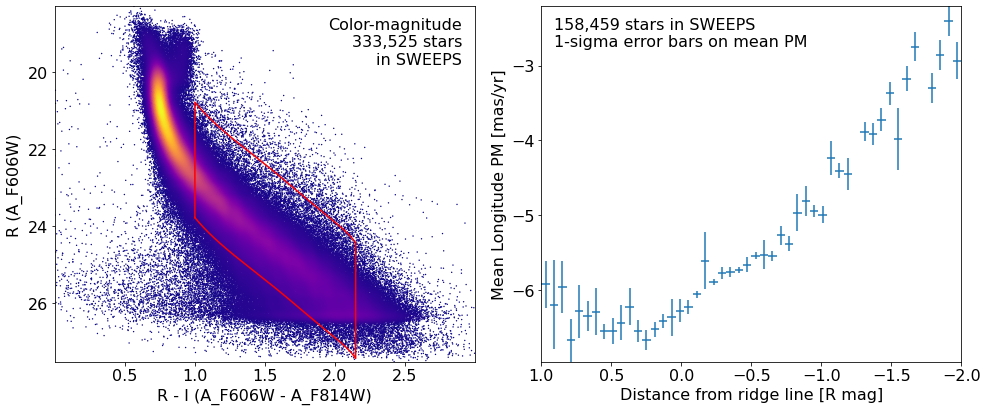

In [47]:
# PM的分级分布与从脊线偏移的星等
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# Weighted histogram
dmagmin = -2.0
dmagmax = 1.0
xmax = axes[0][wy[-1]]
# xmin = axes[0][wy[0]]
xmin = 1.0
wsel = np.where((y-yloc >= dmagmin) & (y-yloc <= dmagmax) & (x >= xmin) & (x <= xmax))[0]

x2 = y[wsel]-yloc[wsel]
y2 = lpm[wsel]-lpm.mean()
hrange = (dmagmin, dmagmax)
hbins = 50
count1d, xedge1d = np.histogram(x2,range=hrange,bins=hbins)
lpm_sum1d = np.histogram(x2,range=hrange,bins=hbins,weights=y2)[0]
lpm_sumsq1d = np.histogram(x2,range=hrange,bins=hbins,weights=y2**2)[0]

ccount1d = count1d.clip(1)
lpm_mean1d = lpm_sum1d/ccount1d
lpm_rms1d = np.sqrt(lpm_sumsq1d/ccount1d-lpm_mean1d**2)
lpm_msigma1d = lpm_rms1d/np.sqrt(ccount1d)
lpm_mean1d += lpm.mean()

x1d = 0.5*(xedge1d[1:]+xedge1d[:-1])

plt.rcParams.update({'font.size': 16})
plt.figure(1,(14,6))

sub1 = plt.subplot(121)
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('R - I (A_F606W - A_F814W)')
plt.ylabel('R (A_F606W)')
plt.text(.97,.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
xboundary = np.hstack((axes[0][wy],axes[0][wy[::-1]]))
yboundary = np.hstack((ridgey+dmagmax,ridgey[::-1]+dmagmin))
wb = np.where((xboundary >= xmin) & (xboundary <= xmax))
xboundary = xboundary[wb]
yboundary = yboundary[wb]
print(xboundary[0],yboundary[0],xboundary[-1],yboundary[-1])
print(xboundary.shape,yboundary.shape)
xboundary = np.append(xboundary,xboundary[0])
yboundary = np.append(yboundary,yboundary[0])
plt.plot(xboundary, yboundary, color='red')

sub1 = plt.subplot(122)
# don't plot huge error points
wp = np.where(lpm_msigma1d < 1)
plt.errorbar(x1d[wp], lpm_mean1d[wp], xerr=(xedge1d[1]-xedge1d[0])/2.0,
               yerr=lpm_msigma1d[wp], linestyle='')
plt.autoscale(tight=True)
plt.xlabel('Distance from ridge line [R mag]')
plt.ylabel('Mean Longitude PM [mas/yr]')
plt.gca().invert_xaxis()
plt.text(.03,.97,'{:,} stars in SWEEPS\n1-sigma error bars on mean PM'.format(len(x2)),
       horizontalalignment='left', verticalalignment='top',
       transform=plt.gca().transAxes)
plt.tight_layout()

## Reproduce Figure 1 from  <a href="https://ui.adsabs.harvard.edu/abs/2014ApJ...790..164C">Calamida et al. 2014</a>

<img src="https://s3.amazonaws.com/aasie/images/0004-637X/790/2/164/apj498303f1_hr.jpg" />

Plotting 156342 of 333525 points
Selected 333,525 low-noise objects
Selected 2,797 red objects
Initially selected 59,605 MS objects
Selected 2,797 MS objects closest to ridge


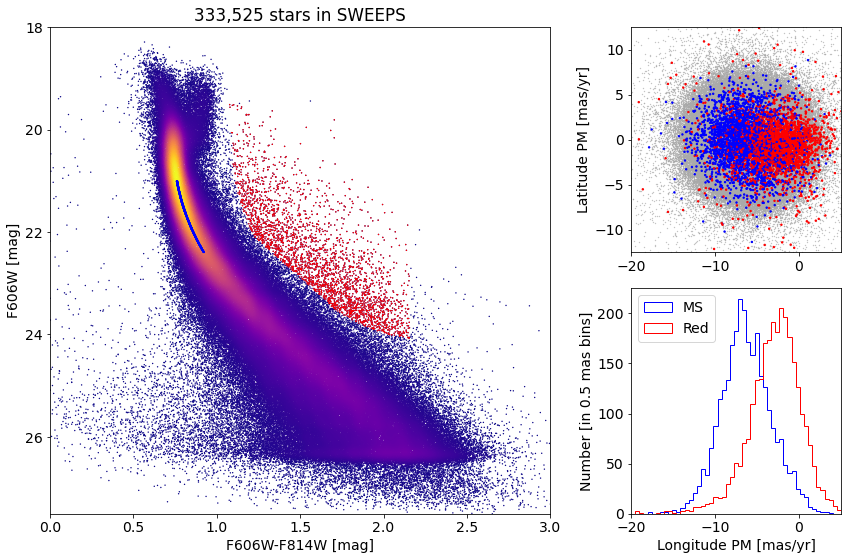

In [48]:
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]

# Calculate the point density
x = np.array(RminusI[w])
y = np.array(f606w[w])
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.1)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

# locate ridge line in magnitude as a function of color
xloc = ridge_color(y)
ridgex = ridge_color(axes[1][wx])

# locate ridge line in color as function of magnitude
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# low-noise objects
print("Selected {:,} low-noise objects".format(len(w)))

# red objects
ylim = yloc - 1.5 - (yloc - 25.0).clip(0)/(1+10.0**(-0.4*(yloc-26.0)))
wred = np.where((y<25) & (y > 19.5) & (y < ylim) & (x-xloc > 0.35))[0]
#wred = np.where((y<25) & (y > 19.5) & ((y-yloc) < -1.5)
#                   & (x-xloc > 0.3))[0]
#                   & (x > 1.1) & (x < 2.5) & (x-xloc > 0.2))[0]
print("Selected {:,} red objects".format(len(wred)))
# main sequence objects
wmain = np.where((y>21) & (y<22.4) & (np.abs(x-xloc) < 0.1))[0]
print("Initially selected {:,} MS objects".format(len(wmain)))
# sort by distance from ridge and select the closest
wmain = wmain[np.argsort(np.abs(x[wmain]-xloc[wmain]))]
wmain = wmain[:len(wred)]
print("Selected {:,} MS objects closest to ridge".format(len(wmain)))

plt.rcParams.update({'font.size': 14})

plt.figure(1,(12,8))
plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
plt.scatter(xs,ys,c=zs,s=2,cmap='plasma',edgecolor='none')
plt.scatter(x[wred],y[wred],c='red',s=2,edgecolor='none')
plt.scatter(x[wmain],y[wmain],c='blue',s=2,edgecolor='none')
plt.xlim(0,3)
plt.ylim(18,27.5)
plt.xlabel('F606W-F814W [mag]')
plt.ylabel('F606W [mag]')
plt.gca().invert_yaxis()
plt.title('{:,} stars in SWEEPS'.format(len(x)))

lrange = (-20,5)
brange = (-12.5,12.5)

# plot MS and red points in random order
wsel = w[np.append(wmain,wred)]
colors = np.array(['blue']*len(wsel))
colors[len(wmain):] = 'red'
irs = np.argsort(np.random.random(len(wsel)))
wsel = wsel[irs]
colors = colors[irs]

plt.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)
plt.scatter(tab['lpm'][w],tab['bpm'][w],c='darkgray',s=0.1)
plt.scatter(tab['lpm'][wsel],tab['bpm'][wsel],c=colors,s=2)
plt.xlim(*lrange)
plt.ylim(*brange)
plt.ylabel('Latitude PM [mas/yr]')

plt.subplot2grid((2,3), (1,2), rowspan=1, colspan=1)
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
plt.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue',
           histtype='step')
plt.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red',
           histtype='step')
plt.xlim(*lrange)
plt.xlabel('Longitude PM [mas/yr]')
plt.ylabel('Number [in {:.2} mas bins]'.format(bin))
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('{}sweeps_calamida.png'.format(resPath))

|# Mean and median proper motions of bulge stars compared with SgrA* (-6.379 $\pm$ 0.026, -0.202 $\pm$ 0.019) mas/yr  <a href="http://adsabs.harvard.edu/abs/2004ApJ...616..872R">Reid and Brunthaler (2004)</a>

In [49]:
lpmmain=np.mean(tab['lpm'][w[wmain]])
bpmmain=np.mean(tab['bpm'][w[wmain]])

norm=1.0/np.sqrt(len(tab['lpm'][w[wmain]]))
print("Bulge stars mean PM   longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.mean(tab['lpm'][w[wmain]]), norm*np.std(tab['lpm'][w[wmain]]),
    np.mean(tab['bpm'][w[wmain]]), norm*np.std(tab['bpm'][w[wmain]])
    ))


norm=1.2533/np.sqrt(len(tab['lpm'][w[wmain]]))
print("Bulge stars median PM longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.median(tab['lpm'][w[wmain]]), norm*np.std(tab['lpm'][w[wmain]]),
    np.median(tab['bpm'][w[wmain]]), norm*np.std(tab['bpm'][w[wmain]])
    ))

Bulge stars mean PM   longitude -6.31 +- 0.059 latitude -0.13 +- 0.053
Bulge stars median PM longitude -6.45 +- 0.074 latitude -0.13 +- 0.067


# White Dwarfs <a class="anchor" id="wd"></a>

Plotting 156617 of 333525 points
Selected 333,525 low-noise objects
Selected 2,797 red objects
Initially selected 59,605 MS objects
Selected 2,797 MS objects closest to ridge


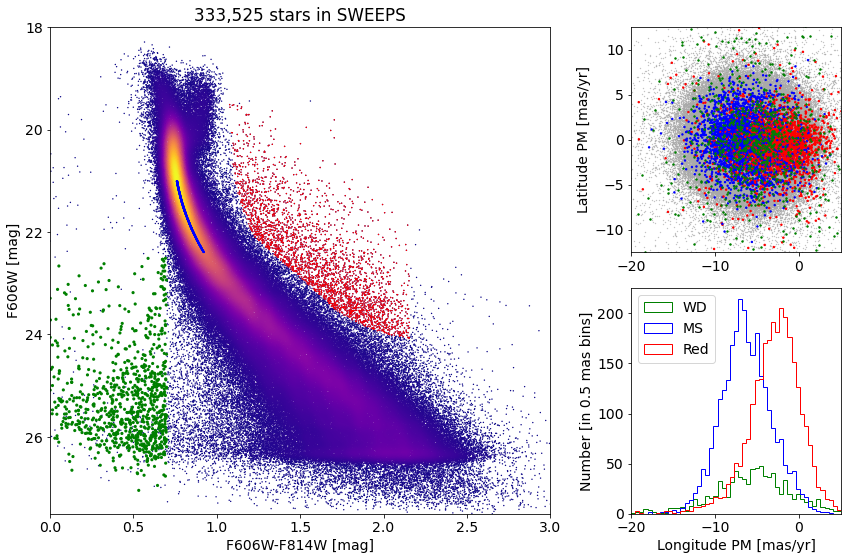

In [57]:
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]

wwd = np.where((RminusI < 0.7)
               & (RminusI > 0)
               & (f606w > 22.5)
               & good
               & (tab['lpm'] < 5)
               & (tab['lpm'] > -20))[0]
xwd = np.array(RminusI[wwd])
ywd = np.array(f606w[wwd])

# Calculate the point density
x = np.array(RminusI[w])
y = np.array(f606w[w])

myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.1)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

# locate ridge line in magnitude as a function of color
xloc = ridge_color(y)
ridgex = ridge_color(axes[1][wx])

# locate ridge line in color as function of magnitude
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# low-noise objects
print("Selected {:,} low-noise objects".format(len(w)))

# red objects
ylim = yloc - 1.5 - (yloc - 25.0).clip(0)/(1+10.0**(-0.4*(yloc-26.0)))
wred = np.where((y<25) & (y > 19.5) & (y < ylim) & (x-xloc > 0.35))[0]
#wred = np.where((y<25) & (y > 19.5) & ((y-yloc) < -1.5)
#                   & (x-xloc > 0.3))[0]
#                   & (x > 1.1) & (x < 2.5) & (x-xloc > 0.2))[0]
print("Selected {:,} red objects".format(len(wred)))
# main sequence objects
wmain = np.where((y>21) & (y<22.4) & (np.abs(x-xloc) < 0.1))[0]
print("Initially selected {:,} MS objects".format(len(wmain)))
# sort by distance from ridge and select the closest
wmain = wmain[np.argsort(np.abs(x[wmain]-xloc[wmain]))]
wmain = wmain[:len(wred)]
print("Selected {:,} MS objects closest to ridge".format(len(wmain)))

plt.rcParams.update({'font.size': 14})

plt.figure(1,(12,8))
plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
plt.scatter(xs,ys,c=zs,s=2,cmap='plasma',edgecolor='none')
plt.scatter(x[wred],y[wred],c='red',s=2,edgecolor='none')
plt.scatter(x[wmain],y[wmain],c='blue',s=2,edgecolor='none')
plt.scatter(xwd,ywd,c='green',s=10,edgecolor='none')
plt.xlim(0,3)
plt.ylim(18,27.5)
plt.xlabel('F606W-F814W [mag]')
plt.ylabel('F606W [mag]')
plt.gca().invert_yaxis()
plt.title('{:,} stars in SWEEPS'.format(len(x)))

lrange = (-20,5)
brange = (-12.5,12.5)

# plot MS and red points in random order
wsel = w[np.append(wmain,wred)]
colors = np.array(['blue']*len(wsel))
colors[len(wmain):] = 'red'
irs = np.argsort(np.random.random(len(wsel)))
wsel = wsel[irs]
colors = colors[irs]

plt.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)
plt.scatter(tab['lpm'][w],tab['bpm'][w],c='darkgray',s=0.1)
plt.scatter(tab['lpm'][wsel],tab['bpm'][wsel],c=colors,s=2)
plt.scatter(tab['lpm'][wwd],tab['bpm'][wwd],c='green',s=2)
plt.xlim(*lrange)
plt.ylim(*brange)
plt.ylabel('Latitude PM [mas/yr]')

plt.subplot2grid((2,3), (1,2), rowspan=1, colspan=1)
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
plt.hist(tab['lpm'][wwd], range=lrange, bins=bincount, label='WD', color='green',
           histtype='step')
plt.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue',
           histtype='step')
plt.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red',
           histtype='step')
plt.xlim(*lrange)
plt.xlabel('Longitude PM [mas/yr]')
plt.ylabel('Number [in {:.2} mas bins]'.format(bin))
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('{}sweeps_calamida_wd.png'.format(resPath))

## White dwarf mean PM and uncertainity

In [58]:
norm=1.0/np.sqrt(len(tab['lpm'][wwd]))
print("WD PM mean +- stdev longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.mean(tab['lpm'][wwd]), norm*np.std(tab['lpm'][wwd]),
    np.mean(tab['bpm'][wwd]), norm*np.std(tab['bpm'][wwd])
    ))

WD PM mean +- stdev longitude -5.60 +- 0.152 latitude -0.03 +- 0.245


## WDs generally closer to bulge (MS) PM distribution

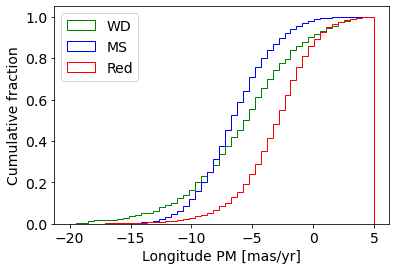

In [59]:
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
plt.hist(tab['lpm'][wwd], range=lrange, bins=bincount, label='WD', color='green',
           histtype='step', density=True, cumulative=1)
plt.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue',
           histtype='step', density=True, cumulative=1)
plt.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red',
           histtype='step', density=True, cumulative=1)
plt.xlabel('Longitude PM [mas/yr]')
plt.ylabel('Cumulative fraction'.format(bin))
plt.legend(loc='upper left')
plt.show()

## Look for quasar candidates (low PM blue stars)  <a class="anchor" id="qsocan"></a>
Note this includes all objects, not just "good" objects with low mag noise, because quasars might be variable too.

<Table length=14>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000710313439 269.74005171773325 -29.196032473369662  0.6265964047671119 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710257520 269.76634477578085 -29.223310166797457  0.7010607226863969 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710307965  269.7417955221381 -29.198593859432016  0.9205935728204635 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710352240  269.7337926320315  -29.18139487545298  0.6946356814006966 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710347699  269.7783405856686  -29.17911931116647 0.41155778832388173 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710305789  269.7500895465239 -29.199706962876274  1.2377985340299074 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710287023 269.73049137354224 -29.208786514685837  0.5886781414210673 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711198572  269.7837898799627 -29.171058346187387 0.24289061146320284 ... 10.997621905233284  2003.436727359001 2014.4343492642342
4000711114267 269.77699533206413 -29.213020339932903    4.24137055513596 ... 12.136400136689947  2003.436727359001  2015.573127495691
4000710335454  269.7613531455845 -29.187206361070864   7.474297329875963 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710273567  269.7541240409338  -29.21578796024474   4.748214164796449 ... 11.341399291029212  2003.436727359001 2014.7781266500303
4000710273213   269.762844233717 -29.215993073596458  2.8491412759641146 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710327380  269.7667196275462 -29.189803905653022  1.4975661577032107 ... 11.341399291029212  2003.436727359001 2014.7781266500303
4000710296308  269.7744892710409  -29.20439243403908  3.8554370972569254 ... 11.371732905164137 2003.4361796620085 2014.8079125671727

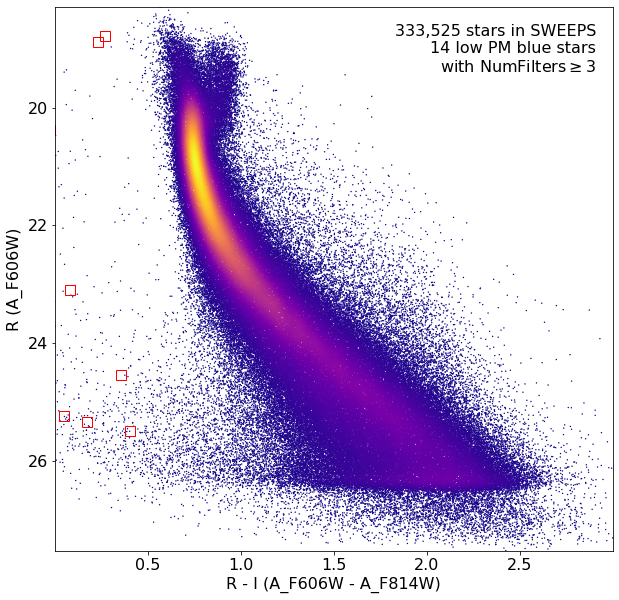

In [60]:
# 寻找候选类星体
# 类星体可变，故针对所有数据进行筛选
# QSO紫外辐射强---蓝
wqso1 = np.where((RminusI < 0.5)
                & (np.sqrt(tab['bpm']**2+tab['lpm']**2) < 1.0)
                & (tab['NumFilters'] > 2))[0]

wqso1 = wqso1[np.argsort(f606w[wqso1])]     # 以星等排序

plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.plot(RminusI[wqso1],f606w[wqso1],'rs',markersize=10,fillstyle='none')       # 标记QSO候选体
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('R - I (A_F606W - A_F814W)')
plt.ylabel('R (A_F606W)')
plt.text(0.97,0.97, """{:,} stars in SWEEPS
{} low PM blue stars
with NumFilters$\\geq3$""".format(len(x),len(wqso1)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
tab[wqso1]

Plotting 14 objects


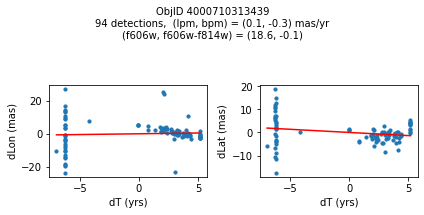

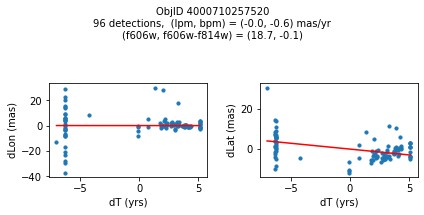

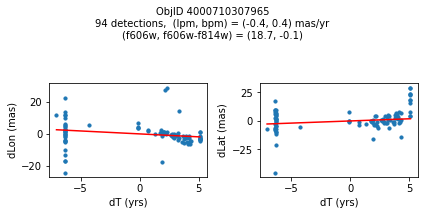

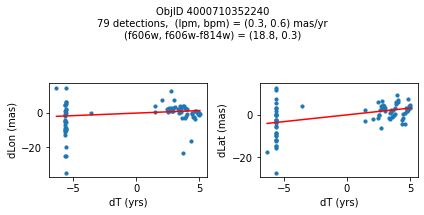

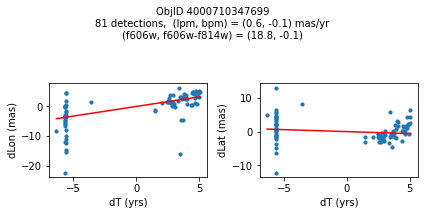

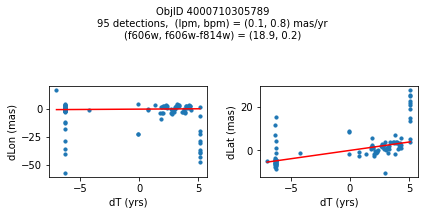

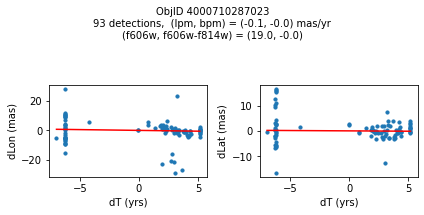

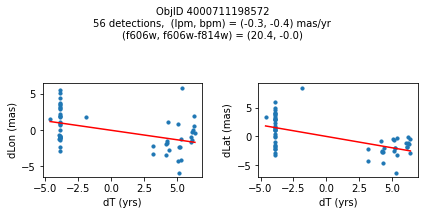

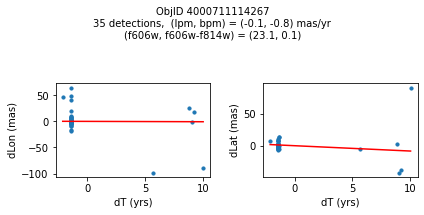

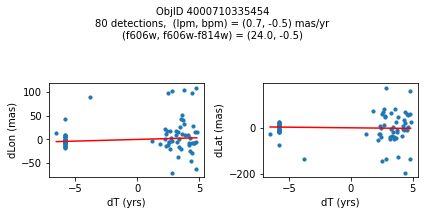

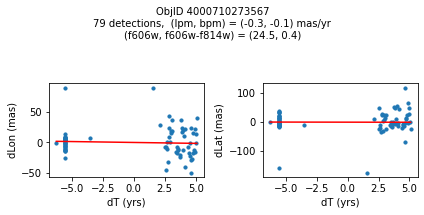

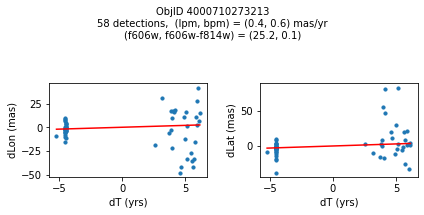

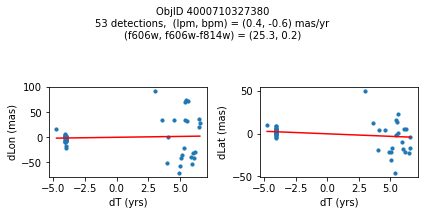

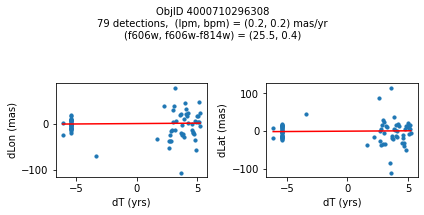

In [61]:
# 绘制QSO候选体时间-自行图像
objid = tab['ObjID']
print("Plotting {} objects".format(len(wqso1)))
for o in objid[wqso1]:
    positions(o,jobs=jobs)

### Try again with different criteria on proper motion fit quality

<Table length=10>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000710347699  269.7783405856686  -29.17911931116647 0.41155778832388173 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000711253077  269.6915378419676  -29.24020145019322  0.4704881733739859 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000711347522 269.70065127433986 -29.232034952664744 0.45813739460650355 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000709025473 269.82873131529516  -29.19512257484812  0.5411363937542479 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000710279756  269.7207706977463 -29.212308555948887 0.41374484392259747 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711345953 269.71277619272627  -29.23130608012401  0.4732191836487131 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000709014231  269.8069522092499  -29.20021994406481  0.3834521659779482 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000710326758 269.75587447129374 -29.189995188046638 0.39923238020201557 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711198572  269.7837898799627 -29.171058346187387 0.24289061146320284 ... 10.997621905233284  2003.436727359001 2014.4343492642342
4000724763944  269.7747901164537  -29.26523403383687 0.43377673171406406 ...   3.00678170959782  2011.801494066038 2014.8082757756358

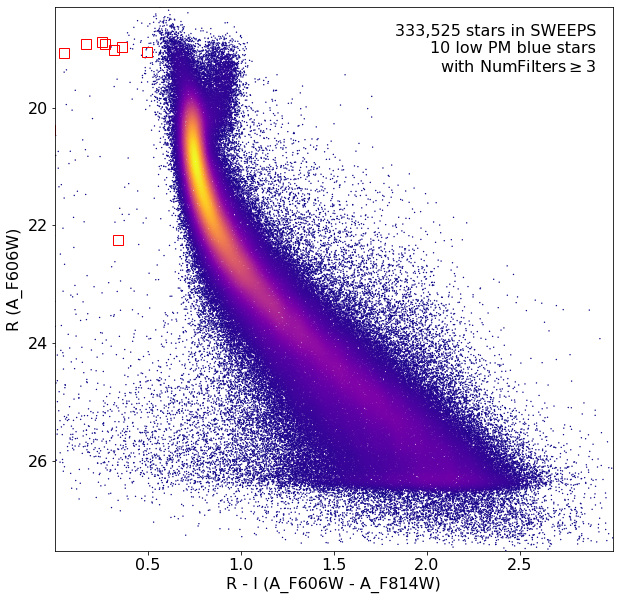

In [62]:
# 采用其它标准
'''
wqso1 = np.where((RminusI < 0.5)
                & (np.sqrt(tab['bpm']**2+tab['lpm']**2) < 1.0)
                & (tab['NumFilters'] > 2))[0]

wqso1 = wqso1[np.argsort(f606w[wqso1])]
'''

wqso2 = np.where((RminusI < 0.5)
                & (np.sqrt(tab['bpm']**2+tab['lpm']**2) < 2.0)
                & (np.sqrt(tab['bpmerr']**2+tab['lpmerr']**2) < 2.0)
                & (tab['pmdev'] < 4.0)
                )[0]
wqso2 = wqso2[np.argsort(f606w[wqso2])]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.plot(RminusI[wqso2],f606w[wqso2],'rs',markersize=10,fillstyle='none')
plt.xlim((xedge[0],xedge[-1]))
plt.ylim((yedge[0],yedge[-1]))
plt.gca().invert_yaxis()
plt.xlabel('R - I (A_F606W - A_F814W)')
plt.ylabel('R (A_F606W)')
plt.text(0.97,0.97, """{:,} stars in SWEEPS
{} low PM blue stars
with NumFilters$\\geq3$""".format(len(x),len(wqso2)),
       horizontalalignment='right', verticalalignment='top',
       transform=plt.gca().transAxes)
tab[wqso2]

Plotting 10 objects


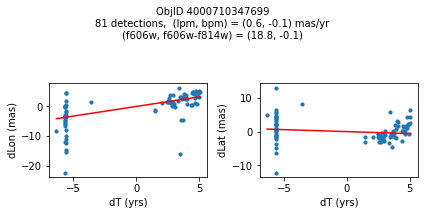

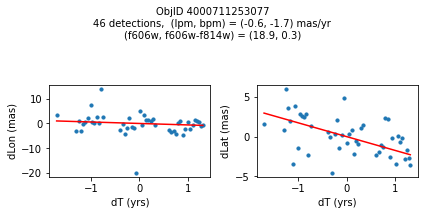

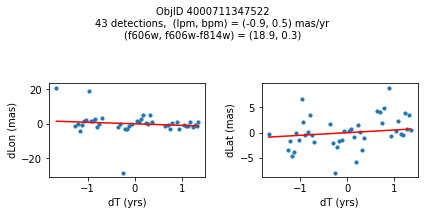

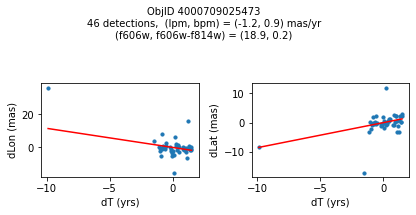

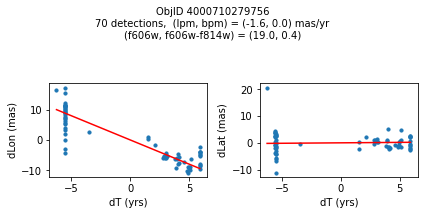

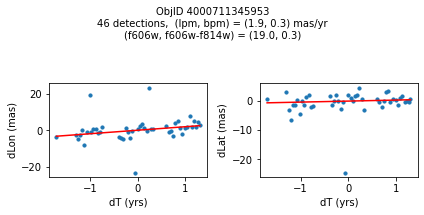

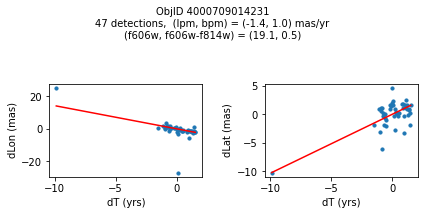

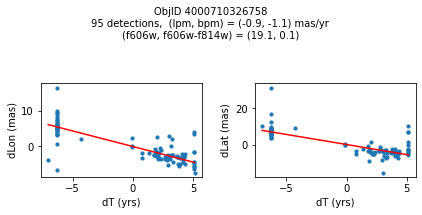

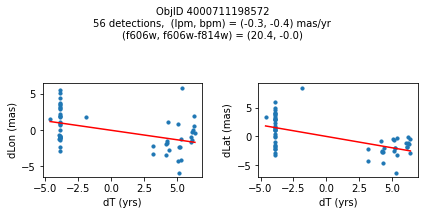

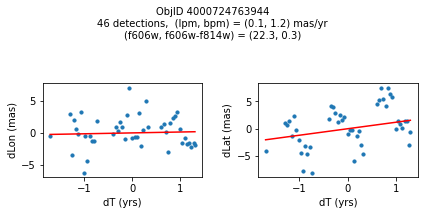

In [63]:
objid = tab['ObjID']
print("Plotting {} objects".format(len(wqso2)))
for o in objid[wqso2]:
    positions(o,jobs=jobs)

# High Proper Motion Objects  <a class="anchor" id="hpm"></a>

Get a list of objects with high, accurately measured proper motions.
Proper motions are measured relative to the main sequence sample (Galactic center approximately).

kde took 6.4 sec
Plotting 98898 of 333743 points


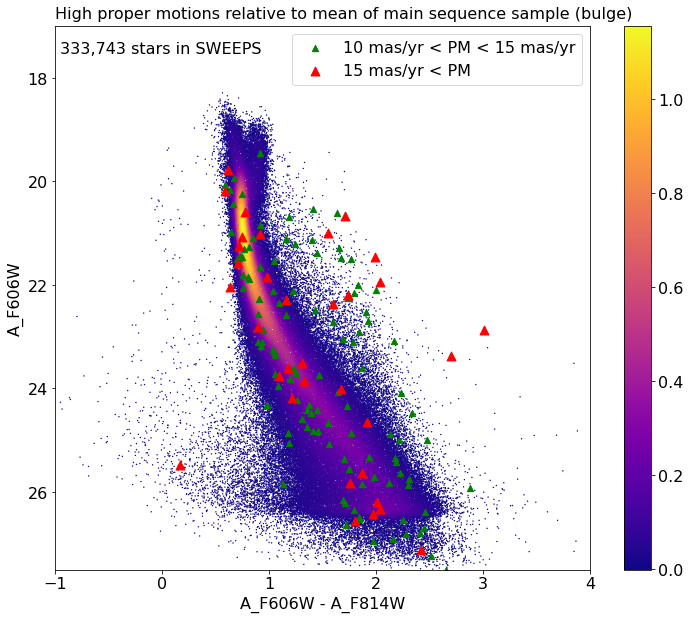

In [64]:
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w
lpm0 = np.array(tab['lpm'])
bpm0 = np.array(tab['bpm'])
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
pmtot0 = np.sqrt((bpm0-bpmmain)**2+(lpm0-lpmmain)**2)
pmerr0 = np.sqrt(bpmerr0**2+lpmerr0**2)

# sort samples by decreasing PM
wpml = np.where((pmtot0 > 12) & (pmtot0 < 15) & (pmerr0 < 1.0) & good)[0]
wpml = wpml[np.argsort(-pmtot0[wpml])]
xpml = np.array(RminusI[wpml])
ypml = np.array(f606w[wpml])

wpmh = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & good)[0]
wpmh = wpmh[np.argsort(-pmtot0[wpmh])]
xpmh = np.array(RminusI[wpmh])
ypmh = np.array(f606w[wpmh])

# Calculate the point density
w = np.where((RminusI > -1) & (RminusI < 4) & good)[0]
x = np.array(RminusI[w])
y = np.array(f606w[w])
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(xs, ys, c=zs, s=2, edgecolor='none', cmap='plasma')
plt.autoscale(tight=True)
plt.xlabel('A_F606W - A_F814W')
plt.ylabel('A_F606W')
plt.gca().invert_yaxis()
plt.xlim(-1,4)
plt.ylim(27.5,17.0)
plt.colorbar()
plt.scatter(xpml, ypml, s=40, c="green", marker ="^",  label='10 mas/yr < PM < 15 mas/yr')   # 标记 10<PM<15 的目标
plt.scatter(xpmh, ypmh, s=80, c="red", marker ="^",  label='15 mas/yr < PM')                 # 标记 PM>15 的目标
plt.text(0.,0.95,'High proper motions relative to mean of main sequence sample (bulge) \n \n {:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='left',
       transform=plt.gca().transAxes)
plt.legend(loc='upper right')
# plt.savefig("{}sweeps_colormag_highpm.png".format(resPath))

Plotting 34 objects


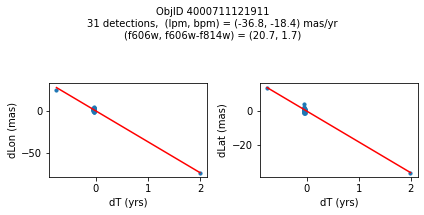

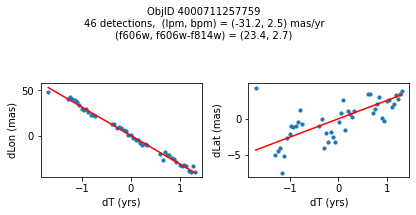

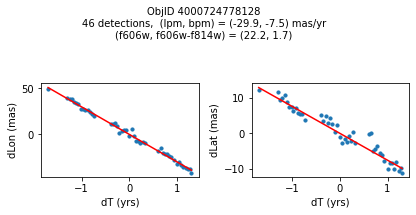

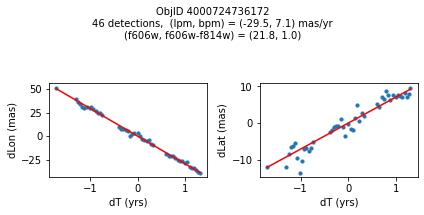

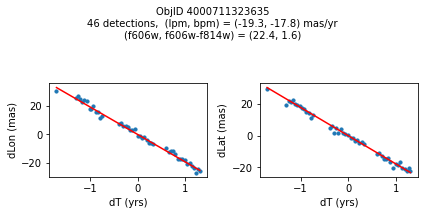

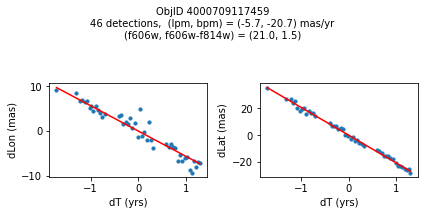

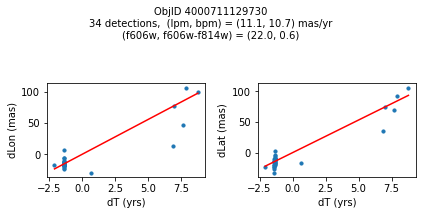

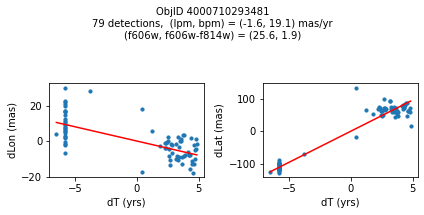

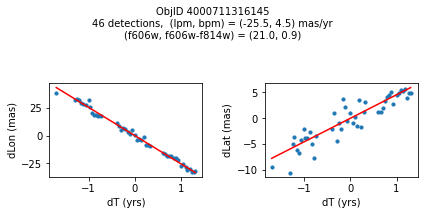

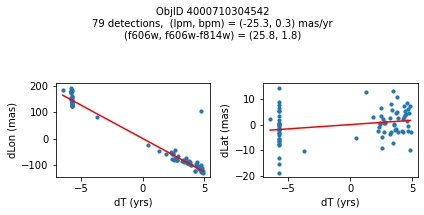

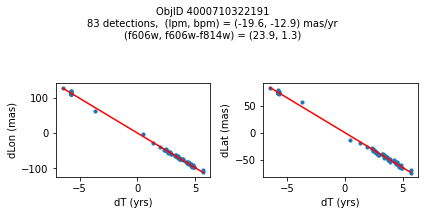

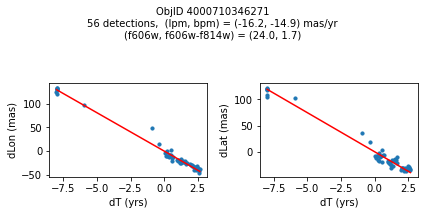

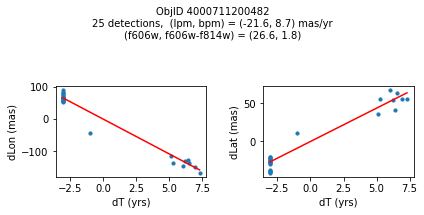

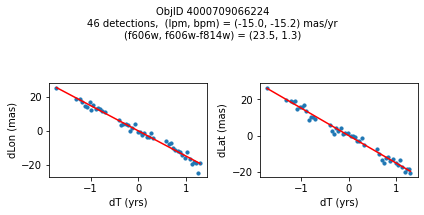

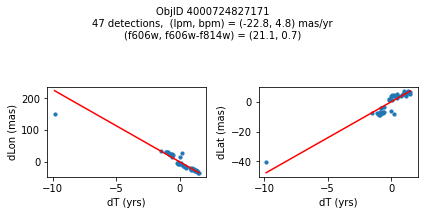

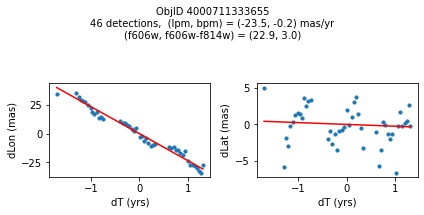

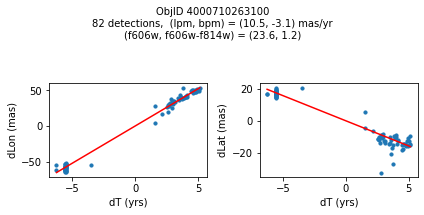

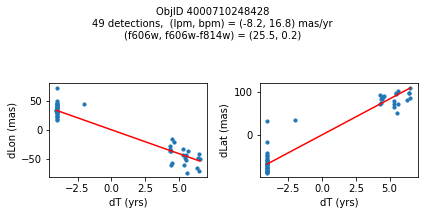

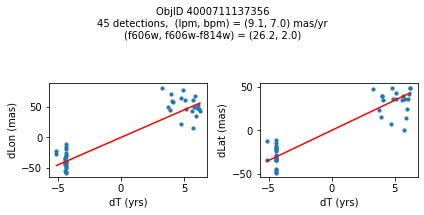

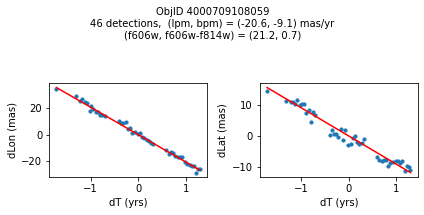

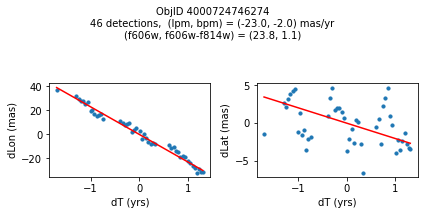

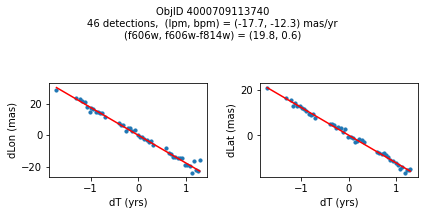

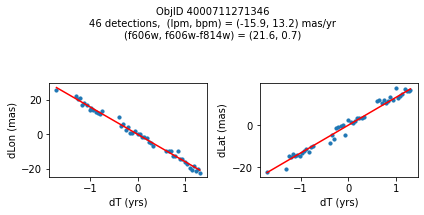

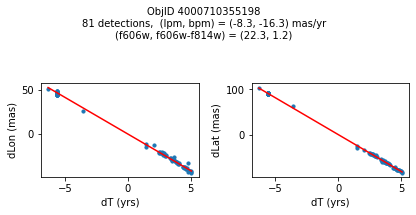

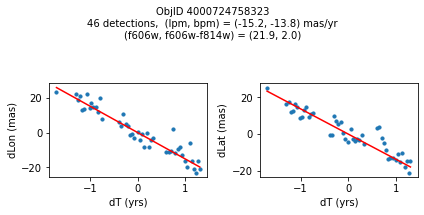

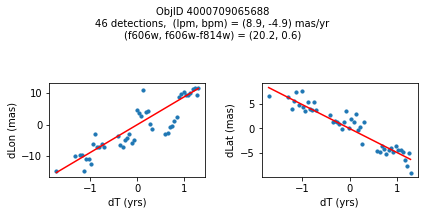

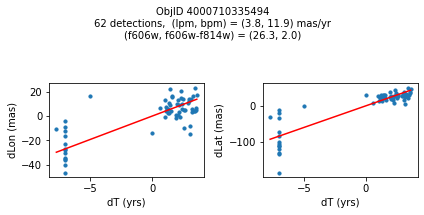

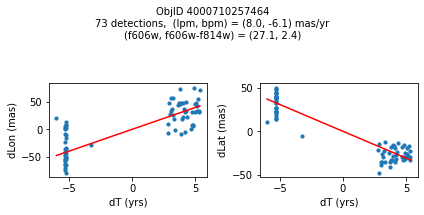

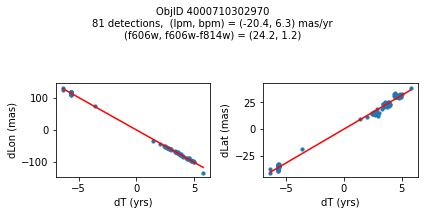

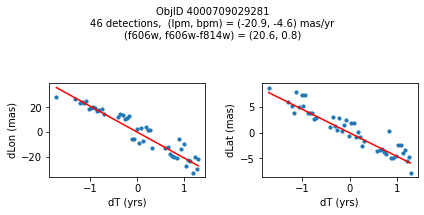

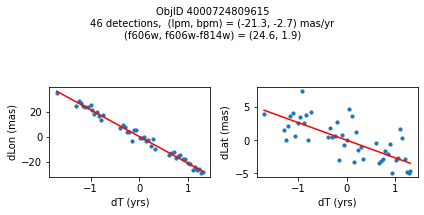

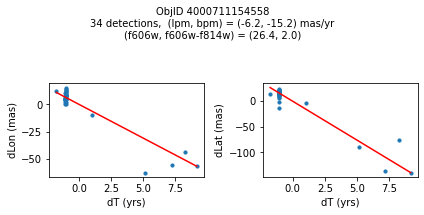

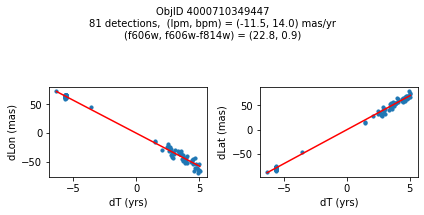

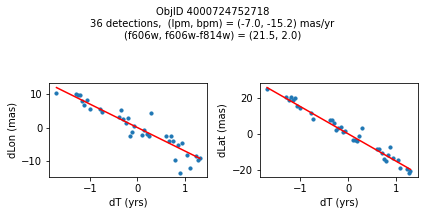

In [52]:
print("Plotting {} objects".format(len(wpmh)))
for o in tab["ObjID"][wpmh]:
    positions(o,jobs=jobs)

# Very red high proper motion objects

Plotting 4 objects


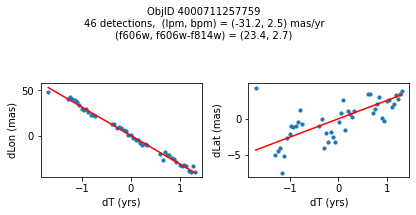

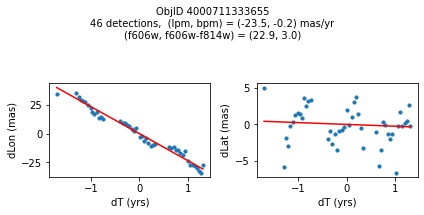

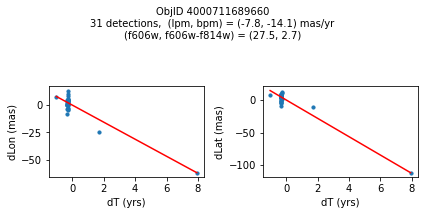

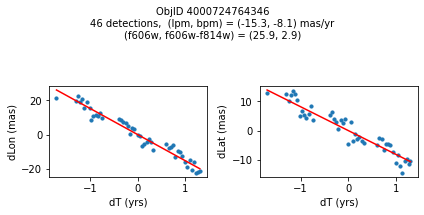

In [53]:
'''
lpm0 = np.array(tab['lpm'])
bpm0 = np.array(tab['bpm'])
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
pmtot0 = np.sqrt((bpm0-bpmmain)**2+(lpm0-lpmmain)**2)
pmerr0 = np.sqrt(bpmerr0**2+lpmerr0**2)
'''
wpmred =  np.where((pmtot0 > 12) & (pmerr0 < 1.0) & (RminusI > 2.6) & good)[0]
print("Plotting {} objects".format(len(wpmred)))
for o in tab["ObjID"][wpmred]:
    positions(o,jobs=jobs)

# Very blue high proper motion objects

Plotting 12 objects


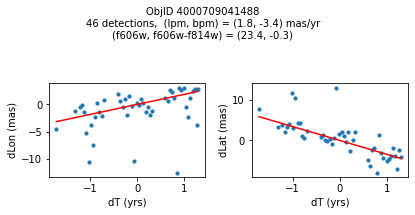

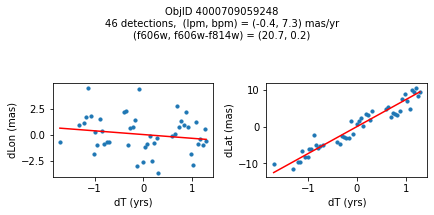

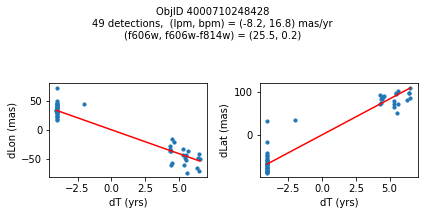

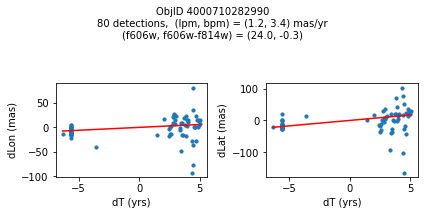

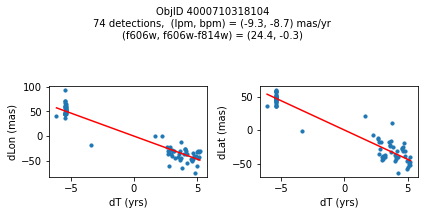

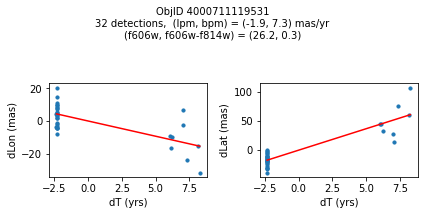

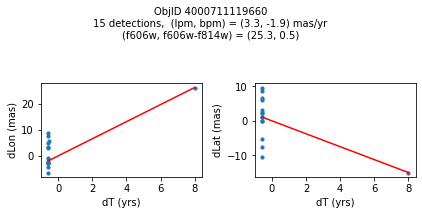

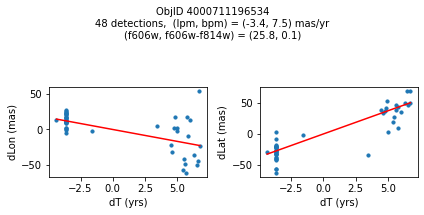

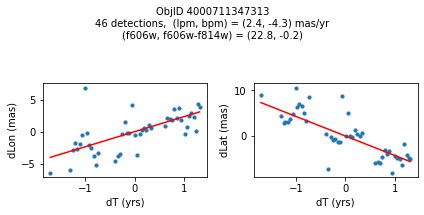

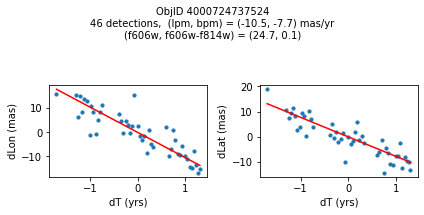

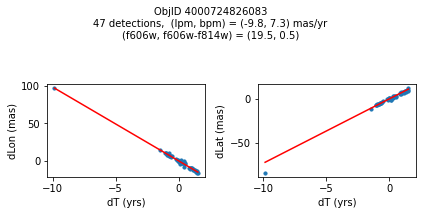

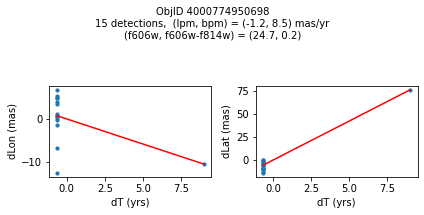

In [54]:
wpmblue =  np.where((pmtot0 > 8) & (pmerr0 < 1.0) & (RminusI < 0.5) & good)[0]
print("Plotting {} objects".format(len(wpmblue)))
for o in tab["ObjID"][wpmblue]:
    positions(o,jobs=jobs)

# Get HLA cutout images for selected objects  <a class="anchor" id="cutouts"></a>

Get HLA color cutout images for the high-PM objects.
The `query_hla` function gets a table of all the color images that are available at a given position using the f814w+f606w filters.
The `get_image` function reads a single cutout image (as a JPEG color image) and returns a PIL image object.

See the documentation on [HLA VO services](http://hla.stsci.edu/hla_help.html#services) and the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web services being used.

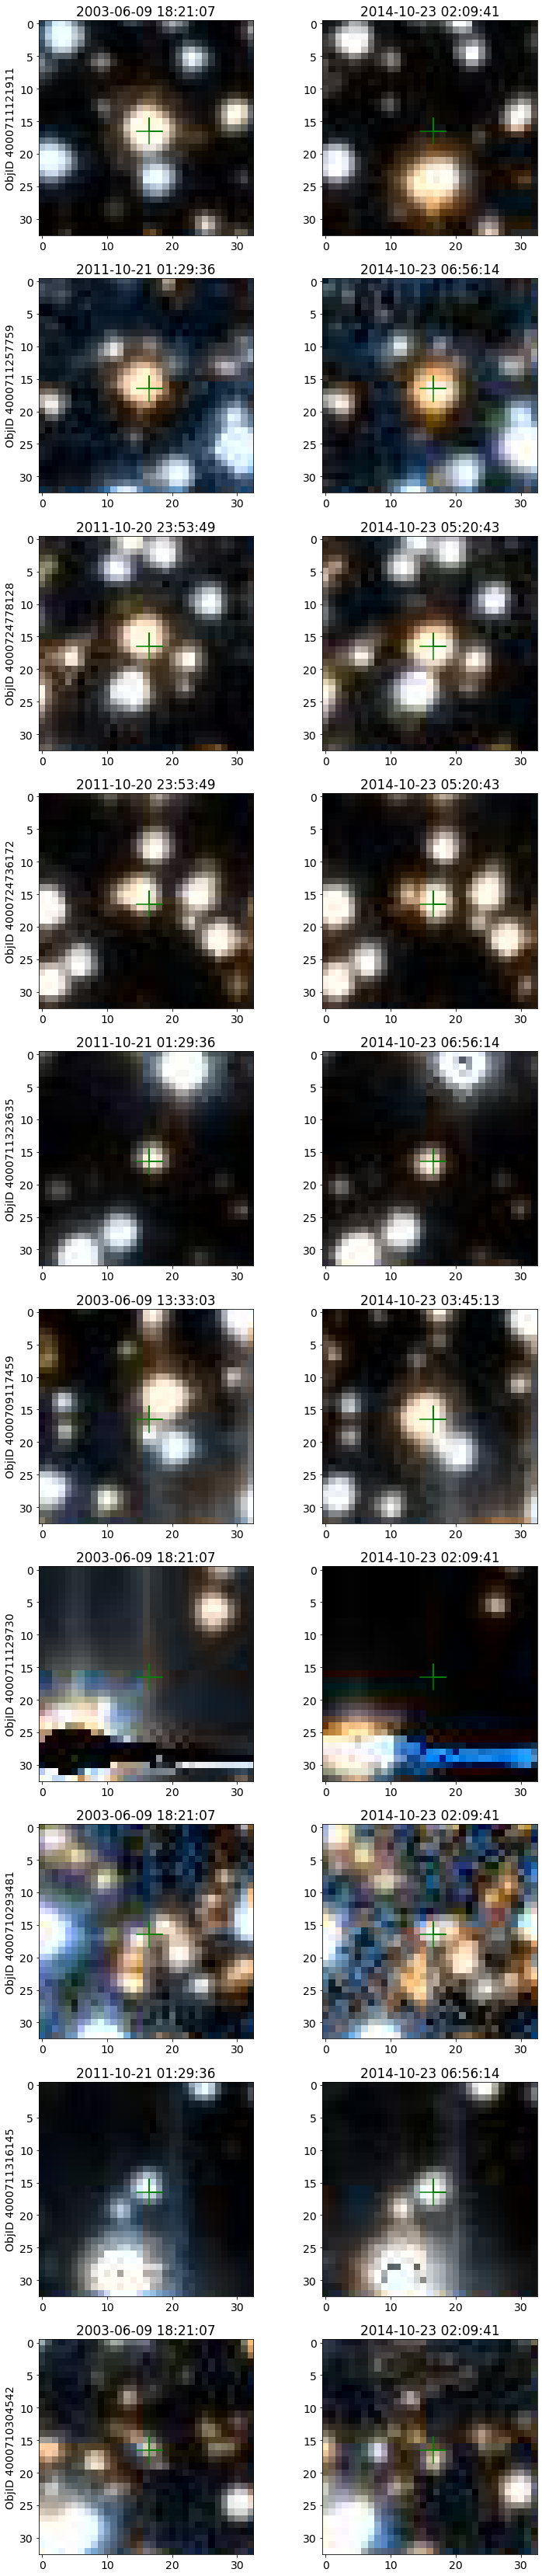

In [55]:
# 函数使用 f814w+f606w 过滤器获取在给定位置可用的所有彩色图像的表
def query_hla(ra,dec,size=0.0,imagetype="color",inst="ACS",format="image/jpeg",
              spectral_elt=("f814w","f606w"),autoscale=95.0,asinh=1,
              naxis=33):
    # convert a list of filters to a comma-separated string
    # 将过滤器列表转换为逗号分隔的字符串
    if not isinstance(spectral_elt,str):
        '''
        isinstance() 函数来判断一个对象是否是一个已知的类型，类似 type()。

        isinstance() 与 type() 区别：
        type() 不会认为子类是一种父类类型，不考虑继承关系。
        isinstance() 会认为子类是一种父类类型，考虑继承关系。
        '''

        spectral_elt = ",".join(spectral_elt)
    siapurl = ("https://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?"
               "pos={ra},{dec}&size={size}&imagetype={imagetype}&inst={inst}"
               "&format={format}&spectral_elt={spectral_elt}"
               "&autoscale={autoscale}&asinh={asinh}"
               "&naxis={naxis}").format(**locals())
    votable = Table.read(siapurl,format="votable")      # votable : Table format used by Virtual Observatory (VO) initiative
    return votable

# `get_image` 函数读取单个剪切图像（作为 JPEG 彩色图像）并返回 PIL 对象。
def get_image(url):

    """Get image from a URL"""

    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


# display earliest and latest images side-by-side
# wsel = wpmred
# wsel = wpmblue
# top 10 highest PM objects
wsel = wpmh[:10] # wpmh: None = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & good)[0]
nim = len(wsel)  # wsel = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & good)[0]
icols = 1        # objects per row
ncols = 2*icols  # two images for each object
nrows = (nim+icols-1)//icols

imsize = 33
xcross = np.array([-1,1,0,0,0])*2 + imsize/2
ycross = np.array([0,0,0,-1,1])*2 + imsize/2

plt.rcParams.update({"font.size":14})
plt.figure(1,(12, (12/ncols)*nrows))
for jim, i in enumerate(wsel):
    hlatab = query_hla(tab["RA"][i],tab["Dec"][i],naxis=imsize)     #传入坐标，获得图像
    hlatab = hlatab[np.argsort(hlatab['StartTime'])]                # sort by observation date
    k = 0
    im1 = get_image(hlatab['URL'][k])       # 获得单个剪切图像，k=1,即最早的图像
    plt.subplot(nrows,ncols,2*jim+1)        # 定义绘图位置：在nrows行，ncols列，的图像集合中，第2*jim+1处绘图
    plt.imshow(im1,origin="upper")
    plt.plot(xcross,ycross,'g')
    plt.title(hlatab['StartTime'][k])
    plt.ylabel("ObjID {}".format(tab["ObjID"][i]))

    k = -1
    im2 = get_image(hlatab['URL'][k])       # 获得单个剪切图像，k=-1,即最近的图像
    plt.subplot(nrows,ncols,2*jim+2)        # 定义绘图位置：在nrows行，ncols列，的图像集合中，第2*jim+2处绘图
    plt.imshow(im2,origin="upper")
    plt.plot(xcross,ycross,'g')
    plt.title(hlatab['StartTime'][k])

    ObjID             RA                Dec              a_f606w           a_f814w              bpm                lpm                 yr                dT       
------------- ----------------- ------------------- ----------------- ------------------ ------------------ ------------------ ----------------- -----------------
4000711121911 269.7367256594695 -29.209699919117618 20.67275047302246 18.963199615478516 -18.43788346257518 -36.80145933087569 2004.194238143401 2.749260607770275


ConnectionError: ('Connection aborted.', ConnectionAbortedError(10053, '你的主机中的软件中止了一个已建立的连接。', None, 10053, None))

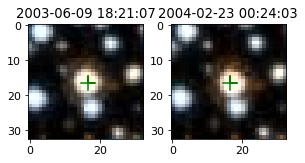

In [56]:
'''
wpmh = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & good)[0]
wpmh = wpmh[np.argsort(-pmtot0[wpmh])]
xpmh = np.array(RminusI[wpmh])
ypmh = np.array(f606w[wpmh])
'''

# 绘制PM最大恒星的img,以时间顺序排列
i = wpmh[0]
print(tab['ObjID','RA','Dec','a_f606w','a_f814w','bpm','lpm','yr','dT'][i])
imsize = 33
hlatab = query_hla(tab["RA"][i],tab["Dec"][i],naxis=imsize)
# sort by observation date
hlatab = hlatab[np.argsort(hlatab['StartTime'])]

nim = len(hlatab)
ncols = 8
nrows = (nim+ncols-1)//ncols

xcross = np.array([-1,1,0,0,0])*2 + imsize/2
ycross = np.array([0,0,0,-1,1])*2 + imsize/2

plt.rcParams.update({"font.size":11})
plt.figure(1,(20, (20/ncols)*nrows))
t0 = time.time()
for k in range(nim):
    im1 = get_image(hlatab['URL'][k])
    plt.subplot(nrows,ncols,k+1)
    plt.imshow(im1,origin="upper")
    plt.plot(xcross,ycross,'g')
    plt.title(hlatab['StartTime'][k])
    if ((k+1) % 10)==0:
        print("{:.1f} s: finished {} of {}".format(time.time()-t0,k+1,nim))
plt.tight_layout()
print("{:.1f} s: finished {}".format(time.time()-t0,nim))